In [ ]:
import jax
import jax.numpy as jnp
import numpy as np
from scipy.integrate import solve_ivp
import equinox as eqx
import diffrax
import optax
import time
import argparse

from neuralhub import params_norm, params_norm_squared, sbplot, RK4

try:
    __IPYTHON__
    _in_ipython_session = True
except NameError:
    _in_ipython_session = False


#%%

if _in_ipython_session:
	# args = argparse.Namespace(time_horizon='39.396473', savepath="results_sgd_9/99999.npz", verbose=1)
	args = argparse.Namespace(time_horizon='15.0', savepath="results_sgd_9/99999.npz", verbose=1)
else:
	parser = argparse.ArgumentParser(description='Description of your program')
	parser.add_argument('--time_horizon', type=str, help='Time Horizon T', default='10.00', required=False)
	parser.add_argument('--savepath', type=str, help='Save the results to', default='results/99999.npz', required=False)
	parser.add_argument('--verbose',type=int, help='Whether to print details or not ?', default=1, required=False)
	args = parser.parse_args()

T = float(args.time_horizon)
savepath = args.savepath
verbose = args.verbose

if verbose:
    print("\n############# Lotka-Volterra with Neural ODE #############\n")
    print("  - Initial time Horizon T: ", T)
    print("  - Savepath: ", savepath)

## Training hps
print_every = 300
nb_epochs = 3500
init_lr_mod = 1e-1
init_lr_T = 10.

traj_length = 25
skip_steps = 1

T_full = 100        ### All trajectories are this long, just in case !


############# Lotka-Volterra with Neural ODE #############

  - Initial time Horizon T:  15.0
  - Savepath:  results_sgd_9/99999.npz


In [ ]:
#%%

def mass_spring_damper(t, state, k, mu, m):
    E = np.array([[0, 1], [-k/m, -mu/m]])
    return E @ state

p = {"k": 1, "mu": 0.25, "m": 1}
t_eval_full = np.linspace(0, T_full, (traj_length-1)*100+1)[::skip_steps]  ## Biggest t we can find !
initial_state = [1.0, 1.0]

solution = solve_ivp(mass_spring_damper, (0,T_full), initial_state, args=p.values(), t_eval=t_eval_full)
data = solution.y.T[None, None, ::, :]

# ## Test 0: Plot the data
# sbplot(t_eval_full, data[0, 0, :, 0], title="Mass-Spring-Damper: Position", x_label="Time", y_label="Position");

# ## Test 1: Plot the interpolation as well
# t_eval_small = np.linspace(0, T, traj_length)
# sol_int = np.interp(t_eval_small, t_eval_full, data[0, 0, :, 0])
# ax = sbplot(t_eval_small, sol_int, "-", title="Interpolation vs Renormalisation", x_label="Time", y_label="Position", label="Interpolated");

# ## Test 2: Integrate a renomalized vector field
# def mass_spring_damper_renormed(t, state, k, mu, m):
#     E = np.array([[0, 1], [-k/m, -mu/m]])
#     return T * (E @ state)
# t_renormed = np.linspace(0, 1, traj_length)
# sol_renormed = solve_ivp(mass_spring_damper_renormed, (0,1), initial_state, args=p.values(), t_eval=t_renormed)
# ax = sbplot(t_eval_small, sol_renormed.y[0], "x", label="Renormalized", y_label="Position", ax=ax);

In [ ]:
# %%

class Processor(eqx.Module):
    matrix: jnp.ndarray

    def __init__(self, in_size, out_size, key=None):
        self.matrix = jnp.array([[0., 0.], [0., 0.]])

    def __call__(self, t, x, args):
        T = args[0]
        return T * (self.matrix @ x)


class NeuralODE(eqx.Module):
    data_size: int
    vector_field: eqx.Module

    def __init__(self, data_size, key=None):
        self.data_size = data_size
        self.vector_field = Processor(data_size, data_size, key=key)

    def __call__(self, x0s, T):
        t_eval = jnp.linspace(0,1,traj_length)

        def integrate(y0):
            # sol = diffrax.diffeqsolve(
            #         diffrax.ODETerm(self.vector_field),
            #         diffrax.Tsit5(),
            #         t0=t_eval[0],
            #         t1=t_eval[-1],
            #         args=(T,),
            #         dt0=1e-3,
            #         y0=y0,
            #         stepsize_controller=diffrax.PIDController(rtol=1e-3, atol=1e-6),
            #         saveat=diffrax.SaveAt(ts=t_eval),
            #         # adjoint=diffrax.BacksolveAdjoint(),
            #         adjoint=diffrax.RecursiveCheckpointAdjoint(),
            #         max_steps=4096
            #     )
            # return sol.ys, sol.stats["num_steps"]

            sol = RK4(fun=self.vector_field, 
                      t_span=(t_eval[0], t_eval[-1]), 
                      y0=y0,
                      args=(T,T, T),
                      t_eval=t_eval, 
                      subdivisions=5)
            return sol, t_eval.shape[0]*5

        trajs, nb_fes = eqx.filter_vmap(integrate)(x0s)
        return trajs, jnp.sum(nb_fes)


def model_real(X_full, t_full, T):
    t_eval = jnp.linspace(0, T, traj_length)

    ## Interpolate X_full to t_eval
    X1 = jnp.interp(t_eval, t_full, X_full[0, ...,0])
    X2 = jnp.interp(t_eval, t_full, X_full[0, ...,1])

    return jnp.concatenate([X1, X2], axis=-1)[None,...], t_eval







class THorizon(eqx.Module):
    T: jnp.ndarray

    def __init__(self, init_T, key=None):
        self.T = jnp.array([init_T])

    def __call__(self):
        return self.T


model = NeuralODE(data_size=2)
T_hrz = THorizon(T)
mega_model = (model, T_hrz)

# model_real(jnp.array([1., 1.])[None, ...], T)
# print(data[0, :, 0].shape)
# model_real(data[:, :, 0], T)

In [ ]:
# %%

def loss_fn(mega_model, batch):
    model, T_hrz = mega_model
    X_full, t_full = batch
    X, _ = model_real(X_full, t_full, T_hrz.T)
    X_hat, _ = model(X_full[...,0,:], T_hrz.T)
    return jnp.mean((X - X_hat)**2)


@eqx.filter_jit
def mega_train_step(mega_model, batch, mega_opt_state):
    loss, mega_grads = eqx.filter_value_and_grad(loss_fn)(mega_model, batch)

    model, T_hrz = mega_model
    grads_mod, grads_T = mega_grads
    opt_state_mod, opt_state_T = mega_opt_state

    updates, opt_state_mod = opt_mod.update(grads_mod, opt_state_mod)
    model = eqx.apply_updates(model, updates)

    grad_norm = params_norm(grads_mod)
    # grad_norm = params_norm_squared(grads_mod)

    ## Only update T if the gradient norm if we are at bad saddle point (hessian has small eigenvalues) ##
    hessians = eqx.filter_hessian(loss_fn)(mega_model, batch)
    # jax.debug.print("hessians {}", hessians)
    hess_theta = hessians[0].vector_field.matrix[0].vector_field.matrix.reshape((4,4))
    eigvals = jnp.linalg.eigh(hess_theta)[0]
    # jax.debug.print("Eigenvalues: {}", eigvals)

    grads_T = jax.lax.cond(jnp.any(jnp.abs(eigvals)<1e-1), 
                            lambda y: jax.tree.map(lambda x: -x, y), 
                            lambda y: jax.tree.map(lambda x: jnp.zeros_like(x), y),
                            grads_T)
    updates, opt_state_T = opt_T.update(grads_T, opt_state_T)
    T_hrz = eqx.apply_updates(T_hrz, updates)

    return (model, T_hrz), (opt_state_mod, opt_state_T), loss, grad_norm



# @eqx.filter_jit
# def mega_train_step_fine(mega_model, batch, mega_opt_state):
#     loss, mega_grads = eqx.filter_value_and_grad(loss_fn)(mega_model, batch)

#     model, T_hrz = mega_model
#     grads_mod, grads_T = mega_grads
#     opt_state_mod, opt_state_T = mega_opt_state

#     updates, opt_state_mod = opt_mod.update(grads_mod, opt_state_mod)
#     model = eqx.apply_updates(model, updates)

#     grad_norm = params_norm(grads_mod)
#     # grad_norm = params_norm_squared(grads_mod)

#     ## Only update T if the gradient norm if we are at bad saddle point (hessian has small eigenvalues) ##
#     hessians = eqx.filter_hessian(loss_fn)(mega_model, batch)
#     # jax.debug.print("hessians {}", hessians)
#     hess_theta = hessians[0].vector_field.matrix[0].vector_field.matrix.reshape((4,4))
#     eigvals = jnp.linalg.eigh(hess_theta)[0]
#     # jax.debug.print("Eigenvalues: {}", eigvals)

#     grads_T = jax.lax.cond(jnp.any(jnp.abs(eigvals)<1e-1), 
#                             lambda y: jax.tree.map(lambda x: x, y), 
#                             lambda y: jax.tree.map(lambda x: jnp.zeros_like(x), y),
#                             grads_T)
#     updates, opt_state_T = opt_T.update(grads_T, opt_state_T)
#     T_hrz = eqx.apply_updates(T_hrz, updates)

#     return (model, T_hrz), (opt_state_mod, opt_state_T), loss, grad_norm



opt_mod = optax.adam(init_lr_mod)
opt_state_mod = opt_mod.init(eqx.filter(model, eqx.is_array))

opt_T = optax.adam(init_lr_T)
opt_state_T = opt_T.init(T_hrz)


if verbose:
    print("\n\n=== Beginning Training ... ===")

start_time = time.time()


losses = []
grad_norms = []
theta_list = [model.vector_field.matrix]
T_hrz_list = [T_hrz.T]

batch = data[0, :, :, :], t_eval_full

for epoch in range(nb_epochs):

    mega_model, opt_states, loss, grad_norm = mega_train_step((model, T_hrz), batch, (opt_state_mod, opt_state_T))

    model, T_hrz = mega_model
    opt_state_mod, opt_state_T = opt_states

    losses.append(loss)
    theta_list.append(model.vector_field.matrix)
    grad_norms.append(grad_norm)
    T_hrz_list.append(T_hrz.T)

    if verbose and (epoch%print_every==0 or epoch==nb_epochs-1):
        print(f"    Epoch: {epoch:-5d}      Loss: {loss:.12f}", flush=True)


# for epoch_fine in range(nb_epochs):

#     mega_model, opt_states, loss, grad_norm = mega_train_step_fine((model, T_hrz), batch, (opt_state_mod, opt_state_T))

#     model, T_hrz = mega_model
#     opt_state_mod, opt_state_T = opt_states

#     if verbose and (epoch_fine%print_every==0 or epoch_fine==nb_epochs-1):
#         print(f"    EpochFine: {epoch_fine:-5d}      Loss: {loss:.12f}", flush=True)



losses = jnp.stack(losses)
thetas = jnp.stack(theta_list)
grad_norms = jnp.stack(grad_norms)
T_hrz_list = jnp.stack(T_hrz_list)

wall_time = time.time() - start_time

if verbose:
    print("\nTotal GD training time: %d secs\n" %wall_time, flush=True)
    print("Final model matrix: \n", model.vector_field.matrix)
    print("Final T: ", T_hrz.T)



=== Beginning Training ... ===
    Epoch:     0      Loss: 1.238064050674
    Epoch:   300      Loss: 0.956395983696
    Epoch:   600      Loss: 0.956396639347
    Epoch:   900      Loss: 0.956397533417
    Epoch:  1200      Loss: 0.956398725510
    Epoch:  1500      Loss: 0.956400275230
    Epoch:  1800      Loss: 0.956402122974
    Epoch:  2100      Loss: 0.956404328346
    Epoch:  2400      Loss: 0.956407010555
    Epoch:  2700      Loss: 0.956410050392
    Epoch:  3000      Loss: 0.956413567066
    Epoch:  3300      Loss: 0.956417500973
    Epoch:  3499      Loss: 0.956420600414

Total GD training time: 27 secs

Final model matrix: 
 [[0.5148477  0.51519084]
 [0.5151492  0.5155038 ]]
Final T:  [-73.07604]


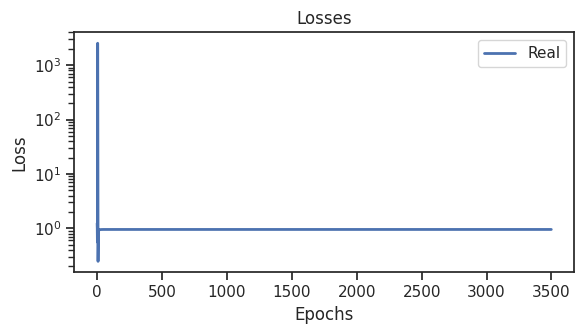

In [ ]:
# %%

## Save results: T, traj_length, losses, thetas, wall_time into a .npz file
np.savez(savepath, time_horizon_init=T, time_horizon_list=T_hrz_list, traj_length=traj_length, losses=losses, thetas=thetas, wall_time=wall_time, grad_norms=grad_norms)

sbplot(losses, "-", label="Real", y_scale="log", title="Losses", x_label="Epochs", y_label="Loss");

In [ ]:
# %%

# ## Test 3: Plot to training predictions
# X_full, t_full = batch
# t_eval_small = np.linspace(0, T_hrz.T, traj_length)

# X, _ = model_real(X_full, t_full, T_hrz.T)
# X_hat, _ = model(X_full[...,0,:], T_hrz.T)

# ax = sbplot(t_eval_small, X_hat[0, :, 0], "-", label="Predicted", title="Real vs Predicted", x_label="Time", y_label="Position")
# ax = sbplot(t_eval_small, X[0, :, 0], "x", label="Real", ax=ax)

In [ ]:
import jax
import jax.numpy as jnp
import numpy as np
from scipy.integrate import solve_ivp
import equinox as eqx
import diffrax
import optax
import time
import argparse

from neuralhub import params_norm, params_norm_squared, sbplot, RK4

try:
    __IPYTHON__
    _in_ipython_session = True
except NameError:
    _in_ipython_session = False


#%%

if _in_ipython_session:
	# args = argparse.Namespace(time_horizon='39.396473', savepath="results_sgd_9/99999.npz", verbose=1)
	args = argparse.Namespace(time_horizon='15.0', savepath="results_sgd_9/99999.npz", verbose=1)
else:
	parser = argparse.ArgumentParser(description='Description of your program')
	parser.add_argument('--time_horizon', type=str, help='Time Horizon T', default='10.00', required=False)
	parser.add_argument('--savepath', type=str, help='Save the results to', default='results/99999.npz', required=False)
	parser.add_argument('--verbose',type=int, help='Whether to print details or not ?', default=1, required=False)
	args = parser.parse_args()

T = float(args.time_horizon)
savepath = args.savepath
verbose = args.verbose

if verbose:
    print("\n############# Lotka-Volterra with Neural ODE #############\n")
    print("  - Initial time Horizon T: ", T)
    print("  - Savepath: ", savepath)

## Training hps
print_every = 300
nb_epochs = 3500
init_lr_mod = 1e-1
init_lr_T = 10.

traj_length = 25
skip_steps = 1

T_full = 100        ### All trajectories are this long, just in case !


############# Lotka-Volterra with Neural ODE #############

  - Initial time Horizon T:  15.0
  - Savepath:  results_sgd_9/99999.npz


In [ ]:
#%%

def mass_spring_damper(t, state, k, mu, m):
    E = np.array([[0, 1], [-k/m, -mu/m]])
    return E @ state

p = {"k": 1, "mu": 0.25, "m": 1}
t_eval_full = np.linspace(0, T_full, (traj_length-1)*100+1)[::skip_steps]  ## Biggest t we can find !
initial_state = [1.0, 1.0]

solution = solve_ivp(mass_spring_damper, (0,T_full), initial_state, args=p.values(), t_eval=t_eval_full)
data = solution.y.T[None, None, ::, :]

# ## Test 0: Plot the data
# sbplot(t_eval_full, data[0, 0, :, 0], title="Mass-Spring-Damper: Position", x_label="Time", y_label="Position");

# ## Test 1: Plot the interpolation as well
# t_eval_small = np.linspace(0, T, traj_length)
# sol_int = np.interp(t_eval_small, t_eval_full, data[0, 0, :, 0])
# ax = sbplot(t_eval_small, sol_int, "-", title="Interpolation vs Renormalisation", x_label="Time", y_label="Position", label="Interpolated");

# ## Test 2: Integrate a renomalized vector field
# def mass_spring_damper_renormed(t, state, k, mu, m):
#     E = np.array([[0, 1], [-k/m, -mu/m]])
#     return T * (E @ state)
# t_renormed = np.linspace(0, 1, traj_length)
# sol_renormed = solve_ivp(mass_spring_damper_renormed, (0,1), initial_state, args=p.values(), t_eval=t_renormed)
# ax = sbplot(t_eval_small, sol_renormed.y[0], "x", label="Renormalized", y_label="Position", ax=ax);

In [ ]:
# %%

class Processor(eqx.Module):
    matrix: jnp.ndarray

    def __init__(self, in_size, out_size, key=None):
        self.matrix = jnp.array([[0., 0.], [0., 0.]])

    def __call__(self, t, x, args):
        T = args[0]
        return T * (self.matrix @ x)


class NeuralODE(eqx.Module):
    data_size: int
    vector_field: eqx.Module

    def __init__(self, data_size, key=None):
        self.data_size = data_size
        self.vector_field = Processor(data_size, data_size, key=key)

    def __call__(self, x0s, T):
        t_eval = jnp.linspace(0,1,traj_length)

        def integrate(y0):
            # sol = diffrax.diffeqsolve(
            #         diffrax.ODETerm(self.vector_field),
            #         diffrax.Tsit5(),
            #         t0=t_eval[0],
            #         t1=t_eval[-1],
            #         args=(T,),
            #         dt0=1e-3,
            #         y0=y0,
            #         stepsize_controller=diffrax.PIDController(rtol=1e-3, atol=1e-6),
            #         saveat=diffrax.SaveAt(ts=t_eval),
            #         # adjoint=diffrax.BacksolveAdjoint(),
            #         adjoint=diffrax.RecursiveCheckpointAdjoint(),
            #         max_steps=4096
            #     )
            # return sol.ys, sol.stats["num_steps"]

            sol = RK4(fun=self.vector_field, 
                      t_span=(t_eval[0], t_eval[-1]), 
                      y0=y0,
                      args=(T,T, T),
                      t_eval=t_eval, 
                      subdivisions=5)
            return sol, t_eval.shape[0]*5

        trajs, nb_fes = eqx.filter_vmap(integrate)(x0s)
        return trajs, jnp.sum(nb_fes)


def model_real(X_full, t_full, T):
    t_eval = jnp.linspace(0, T, traj_length)

    ## Interpolate X_full to t_eval
    X1 = jnp.interp(t_eval, t_full, X_full[0, ...,0])
    X2 = jnp.interp(t_eval, t_full, X_full[0, ...,1])

    return jnp.concatenate([X1, X2], axis=-1)[None,...], t_eval







class THorizon(eqx.Module):
    T: jnp.ndarray

    def __init__(self, init_T, key=None):
        self.T = jnp.array([init_T])

    def __call__(self):
        return self.T


model = NeuralODE(data_size=2)
T_hrz = THorizon(T)
mega_model = (model, T_hrz)

# model_real(jnp.array([1., 1.])[None, ...], T)
# print(data[0, :, 0].shape)
# model_real(data[:, :, 0], T)

In [ ]:
# %%

def loss_fn(mega_model, batch):
    model, T_hrz = mega_model
    X_full, t_full = batch
    X, _ = model_real(X_full, t_full, T_hrz.T)
    X_hat, _ = model(X_full[...,0,:], T_hrz.T)
    return jnp.mean((X - X_hat)**2)


@eqx.filter_jit
def mega_train_step(mega_model, batch, mega_opt_state):
    loss, mega_grads = eqx.filter_value_and_grad(loss_fn)(mega_model, batch)

    model, T_hrz = mega_model
    grads_mod, grads_T = mega_grads
    opt_state_mod, opt_state_T = mega_opt_state

    updates, opt_state_mod = opt_mod.update(grads_mod, opt_state_mod)
    model = eqx.apply_updates(model, updates)

    grad_norm = params_norm(grads_mod)
    # grad_norm = params_norm_squared(grads_mod)

    # ## Only update T if the gradient norm if we are at bad saddle point (hessian has small eigenvalues) ##
    # hessians = eqx.filter_hessian(loss_fn)(mega_model, batch)
    # # jax.debug.print("hessians {}", hessians)
    # hess_theta = hessians[0].vector_field.matrix[0].vector_field.matrix.reshape((4,4))
    # eigvals = jnp.linalg.eigh(hess_theta)[0]
    # # jax.debug.print("Eigenvalues: {}", eigvals)

    # grads_T = jax.lax.cond(jnp.any(jnp.abs(eigvals)<1e-1), 
    #                         lambda y: jax.tree.map(lambda x: -x, y), 
    #                         lambda y: jax.tree.map(lambda x: jnp.zeros_like(x), y),
    #                         grads_T)
    # updates, opt_state_T = opt_T.update(grads_T, opt_state_T)
    # T_hrz = eqx.apply_updates(T_hrz, updates)

    return (model, T_hrz), (opt_state_mod, opt_state_T), loss, grad_norm



# @eqx.filter_jit
# def mega_train_step_fine(mega_model, batch, mega_opt_state):
#     loss, mega_grads = eqx.filter_value_and_grad(loss_fn)(mega_model, batch)

#     model, T_hrz = mega_model
#     grads_mod, grads_T = mega_grads
#     opt_state_mod, opt_state_T = mega_opt_state

#     updates, opt_state_mod = opt_mod.update(grads_mod, opt_state_mod)
#     model = eqx.apply_updates(model, updates)

#     grad_norm = params_norm(grads_mod)
#     # grad_norm = params_norm_squared(grads_mod)

#     ## Only update T if the gradient norm if we are at bad saddle point (hessian has small eigenvalues) ##
#     hessians = eqx.filter_hessian(loss_fn)(mega_model, batch)
#     # jax.debug.print("hessians {}", hessians)
#     hess_theta = hessians[0].vector_field.matrix[0].vector_field.matrix.reshape((4,4))
#     eigvals = jnp.linalg.eigh(hess_theta)[0]
#     # jax.debug.print("Eigenvalues: {}", eigvals)

#     grads_T = jax.lax.cond(jnp.any(jnp.abs(eigvals)<1e-1), 
#                             lambda y: jax.tree.map(lambda x: x, y), 
#                             lambda y: jax.tree.map(lambda x: jnp.zeros_like(x), y),
#                             grads_T)
#     updates, opt_state_T = opt_T.update(grads_T, opt_state_T)
#     T_hrz = eqx.apply_updates(T_hrz, updates)

#     return (model, T_hrz), (opt_state_mod, opt_state_T), loss, grad_norm



opt_mod = optax.adam(init_lr_mod)
opt_state_mod = opt_mod.init(eqx.filter(model, eqx.is_array))

opt_T = optax.adam(init_lr_T)
opt_state_T = opt_T.init(T_hrz)


if verbose:
    print("\n\n=== Beginning Training ... ===")

start_time = time.time()


losses = []
grad_norms = []
theta_list = [model.vector_field.matrix]
T_hrz_list = [T_hrz.T]

batch = data[0, :, :, :], t_eval_full

for epoch in range(nb_epochs):

    mega_model, opt_states, loss, grad_norm = mega_train_step((model, T_hrz), batch, (opt_state_mod, opt_state_T))

    model, T_hrz = mega_model
    opt_state_mod, opt_state_T = opt_states

    losses.append(loss)
    theta_list.append(model.vector_field.matrix)
    grad_norms.append(grad_norm)
    T_hrz_list.append(T_hrz.T)

    if verbose and (epoch%print_every==0 or epoch==nb_epochs-1):
        print(f"    Epoch: {epoch:-5d}      Loss: {loss:.12f}", flush=True)


# for epoch_fine in range(nb_epochs):

#     mega_model, opt_states, loss, grad_norm = mega_train_step_fine((model, T_hrz), batch, (opt_state_mod, opt_state_T))

#     model, T_hrz = mega_model
#     opt_state_mod, opt_state_T = opt_states

#     if verbose and (epoch_fine%print_every==0 or epoch_fine==nb_epochs-1):
#         print(f"    EpochFine: {epoch_fine:-5d}      Loss: {loss:.12f}", flush=True)



losses = jnp.stack(losses)
thetas = jnp.stack(theta_list)
grad_norms = jnp.stack(grad_norms)
T_hrz_list = jnp.stack(T_hrz_list)

wall_time = time.time() - start_time

if verbose:
    print("\nTotal GD training time: %d secs\n" %wall_time, flush=True)
    print("Final model matrix: \n", model.vector_field.matrix)
    print("Final T: ", T_hrz.T)



=== Beginning Training ... ===
    Epoch:     0      Loss: 1.238064050674
    Epoch:   300      Loss: 0.000565652619
    Epoch:   600      Loss: 0.000000008130
    Epoch:   900      Loss: 0.000000008130
    Epoch:  1200      Loss: 0.000000008125
    Epoch:  1500      Loss: 0.000000008124
    Epoch:  1800      Loss: 0.000000008125
    Epoch:  2100      Loss: 0.000000008125
    Epoch:  2400      Loss: 0.000000008125
    Epoch:  2700      Loss: 0.000000008125
    Epoch:  3000      Loss: 0.000000008125
    Epoch:  3300      Loss: 0.000000008128
    Epoch:  3499      Loss: 0.000000008131

Total GD training time: 7 secs

Final model matrix: 
 [[-4.4309651e-05  1.0002022e+00]
 [-1.0001602e+00 -2.5032604e-01]]
Final T:  [15.]


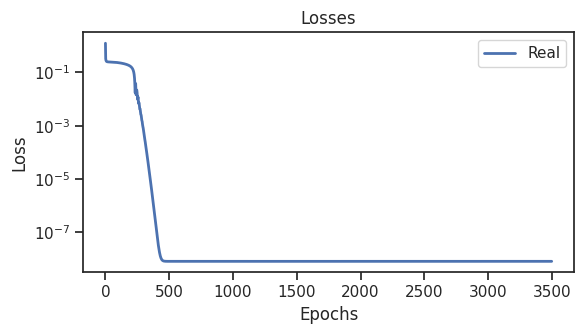

In [ ]:
# %%

## Save results: T, traj_length, losses, thetas, wall_time into a .npz file
np.savez(savepath, time_horizon_init=T, time_horizon_list=T_hrz_list, traj_length=traj_length, losses=losses, thetas=thetas, wall_time=wall_time, grad_norms=grad_norms)

sbplot(losses, "-", label="Real", y_scale="log", title="Losses", x_label="Epochs", y_label="Loss");

In [ ]:
# %%

# ## Test 3: Plot to training predictions
# X_full, t_full = batch
# t_eval_small = np.linspace(0, T_hrz.T, traj_length)

# X, _ = model_real(X_full, t_full, T_hrz.T)
# X_hat, _ = model(X_full[...,0,:], T_hrz.T)

# ax = sbplot(t_eval_small, X_hat[0, :, 0], "-", label="Predicted", title="Real vs Predicted", x_label="Time", y_label="Position")
# ax = sbplot(t_eval_small, X[0, :, 0], "x", label="Real", ax=ax)

In [ ]:
import jax
import jax.numpy as jnp
import numpy as np
from scipy.integrate import solve_ivp
import equinox as eqx
import diffrax
import optax
import time
import argparse

from neuralhub import params_norm, params_norm_squared, sbplot, RK4

try:
    __IPYTHON__
    _in_ipython_session = True
except NameError:
    _in_ipython_session = False


#%%

if _in_ipython_session:
	# args = argparse.Namespace(time_horizon='39.396473', savepath="results_sgd_9/99999.npz", verbose=1)
	args = argparse.Namespace(time_horizon='15.0', savepath="results_sgd_9/99999.npz", verbose=1)
else:
	parser = argparse.ArgumentParser(description='Description of your program')
	parser.add_argument('--time_horizon', type=str, help='Time Horizon T', default='10.00', required=False)
	parser.add_argument('--savepath', type=str, help='Save the results to', default='results/99999.npz', required=False)
	parser.add_argument('--verbose',type=int, help='Whether to print details or not ?', default=1, required=False)
	args = parser.parse_args()

T = float(args.time_horizon)
savepath = args.savepath
verbose = args.verbose

if verbose:
    print("\n############# Lotka-Volterra with Neural ODE #############\n")
    print("  - Initial time Horizon T: ", T)
    print("  - Savepath: ", savepath)

## Training hps
print_every = 300
nb_epochs = 3500
init_lr_mod = 1e-1
init_lr_T = 10.

traj_length = 25
skip_steps = 1

T_full = 100        ### All trajectories are this long, just in case !


############# Lotka-Volterra with Neural ODE #############

  - Initial time Horizon T:  15.0
  - Savepath:  results_sgd_9/99999.npz


In [ ]:
#%%

def mass_spring_damper(t, state, k, mu, m):
    E = np.array([[0, 1], [-k/m, -mu/m]])
    return E @ state

p = {"k": 1, "mu": 0.25, "m": 1}
t_eval_full = np.linspace(0, T_full, (traj_length-1)*100+1)[::skip_steps]  ## Biggest t we can find !
initial_state = [1.0, 1.0]

solution = solve_ivp(mass_spring_damper, (0,T_full), initial_state, args=p.values(), t_eval=t_eval_full)
data = solution.y.T[None, None, ::, :]

# ## Test 0: Plot the data
# sbplot(t_eval_full, data[0, 0, :, 0], title="Mass-Spring-Damper: Position", x_label="Time", y_label="Position");

# ## Test 1: Plot the interpolation as well
# t_eval_small = np.linspace(0, T, traj_length)
# sol_int = np.interp(t_eval_small, t_eval_full, data[0, 0, :, 0])
# ax = sbplot(t_eval_small, sol_int, "-", title="Interpolation vs Renormalisation", x_label="Time", y_label="Position", label="Interpolated");

# ## Test 2: Integrate a renomalized vector field
# def mass_spring_damper_renormed(t, state, k, mu, m):
#     E = np.array([[0, 1], [-k/m, -mu/m]])
#     return T * (E @ state)
# t_renormed = np.linspace(0, 1, traj_length)
# sol_renormed = solve_ivp(mass_spring_damper_renormed, (0,1), initial_state, args=p.values(), t_eval=t_renormed)
# ax = sbplot(t_eval_small, sol_renormed.y[0], "x", label="Renormalized", y_label="Position", ax=ax);

In [ ]:
# %%

class Processor(eqx.Module):
    matrix: jnp.ndarray

    def __init__(self, in_size, out_size, key=None):
        self.matrix = jnp.array([[0., 0.], [0., 0.]])

    def __call__(self, t, x, args):
        T = args[0]
        return T * (self.matrix @ x)


class NeuralODE(eqx.Module):
    data_size: int
    vector_field: eqx.Module

    def __init__(self, data_size, key=None):
        self.data_size = data_size
        self.vector_field = Processor(data_size, data_size, key=key)

    def __call__(self, x0s, T):
        t_eval = jnp.linspace(0,1,traj_length)

        def integrate(y0):
            # sol = diffrax.diffeqsolve(
            #         diffrax.ODETerm(self.vector_field),
            #         diffrax.Tsit5(),
            #         t0=t_eval[0],
            #         t1=t_eval[-1],
            #         args=(T,),
            #         dt0=1e-3,
            #         y0=y0,
            #         stepsize_controller=diffrax.PIDController(rtol=1e-3, atol=1e-6),
            #         saveat=diffrax.SaveAt(ts=t_eval),
            #         # adjoint=diffrax.BacksolveAdjoint(),
            #         adjoint=diffrax.RecursiveCheckpointAdjoint(),
            #         max_steps=4096
            #     )
            # return sol.ys, sol.stats["num_steps"]

            sol = RK4(fun=self.vector_field, 
                      t_span=(t_eval[0], t_eval[-1]), 
                      y0=y0,
                      args=(T,T, T),
                      t_eval=t_eval, 
                      subdivisions=5)
            return sol, t_eval.shape[0]*5

        trajs, nb_fes = eqx.filter_vmap(integrate)(x0s)
        return trajs, jnp.sum(nb_fes)


def model_real(X_full, t_full, T):
    t_eval = jnp.linspace(0, T, traj_length)

    ## Interpolate X_full to t_eval
    X1 = jnp.interp(t_eval, t_full, X_full[0, ...,0])
    X2 = jnp.interp(t_eval, t_full, X_full[0, ...,1])

    return jnp.concatenate([X1, X2], axis=-1)[None,...], t_eval







class THorizon(eqx.Module):
    T: jnp.ndarray

    def __init__(self, init_T, key=None):
        self.T = jnp.array([init_T])

    def __call__(self):
        return self.T


model = NeuralODE(data_size=2)
T_hrz = THorizon(T)
mega_model = (model, T_hrz)

# model_real(jnp.array([1., 1.])[None, ...], T)
# print(data[0, :, 0].shape)
# model_real(data[:, :, 0], T)

In [ ]:
# %%

def loss_fn(mega_model, batch):
    model, T_hrz = mega_model
    X_full, t_full = batch
    X, _ = model_real(X_full, t_full, T_hrz.T)
    X_hat, _ = model(X_full[...,0,:], T_hrz.T)
    return jnp.mean((X - X_hat)**2)


@eqx.filter_jit
def mega_train_step(mega_model, batch, mega_opt_state):
    loss, mega_grads = eqx.filter_value_and_grad(loss_fn)(mega_model, batch)

    model, T_hrz = mega_model
    grads_mod, grads_T = mega_grads
    opt_state_mod, opt_state_T = mega_opt_state

    updates, opt_state_mod = opt_mod.update(grads_mod, opt_state_mod)
    model = eqx.apply_updates(model, updates)

    grad_norm = params_norm(grads_mod)
    # grad_norm = params_norm_squared(grads_mod)

    ## Only update T if the gradient norm if we are at bad saddle point (hessian has small eigenvalues) ##
    hessians = eqx.filter_hessian(loss_fn)(mega_model, batch)
    # jax.debug.print("hessians {}", hessians)
    hess_theta = hessians[0].vector_field.matrix[0].vector_field.matrix.reshape((4,4))
    eigvals = jnp.linalg.eigh(hess_theta)[0]
    # jax.debug.print("Eigenvalues: {}", eigvals)

    grads_T = jax.lax.cond(jnp.any(jnp.abs(eigvals)<1e-1), 
                            lambda y: jax.tree.map(lambda x: x, y), 
                            lambda y: jax.tree.map(lambda x: jnp.zeros_like(x), y),
                            grads_T)
    updates, opt_state_T = opt_T.update(grads_T, opt_state_T)
    T_hrz = eqx.apply_updates(T_hrz, updates)

    return (model, T_hrz), (opt_state_mod, opt_state_T), loss, grad_norm



# @eqx.filter_jit
# def mega_train_step_fine(mega_model, batch, mega_opt_state):
#     loss, mega_grads = eqx.filter_value_and_grad(loss_fn)(mega_model, batch)

#     model, T_hrz = mega_model
#     grads_mod, grads_T = mega_grads
#     opt_state_mod, opt_state_T = mega_opt_state

#     updates, opt_state_mod = opt_mod.update(grads_mod, opt_state_mod)
#     model = eqx.apply_updates(model, updates)

#     grad_norm = params_norm(grads_mod)
#     # grad_norm = params_norm_squared(grads_mod)

#     ## Only update T if the gradient norm if we are at bad saddle point (hessian has small eigenvalues) ##
#     hessians = eqx.filter_hessian(loss_fn)(mega_model, batch)
#     # jax.debug.print("hessians {}", hessians)
#     hess_theta = hessians[0].vector_field.matrix[0].vector_field.matrix.reshape((4,4))
#     eigvals = jnp.linalg.eigh(hess_theta)[0]
#     # jax.debug.print("Eigenvalues: {}", eigvals)

#     grads_T = jax.lax.cond(jnp.any(jnp.abs(eigvals)<1e-1), 
#                             lambda y: jax.tree.map(lambda x: x, y), 
#                             lambda y: jax.tree.map(lambda x: jnp.zeros_like(x), y),
#                             grads_T)
#     updates, opt_state_T = opt_T.update(grads_T, opt_state_T)
#     T_hrz = eqx.apply_updates(T_hrz, updates)

#     return (model, T_hrz), (opt_state_mod, opt_state_T), loss, grad_norm



opt_mod = optax.adam(init_lr_mod)
opt_state_mod = opt_mod.init(eqx.filter(model, eqx.is_array))

opt_T = optax.adam(init_lr_T)
opt_state_T = opt_T.init(T_hrz)


if verbose:
    print("\n\n=== Beginning Training ... ===")

start_time = time.time()


losses = []
grad_norms = []
theta_list = [model.vector_field.matrix]
T_hrz_list = [T_hrz.T]

batch = data[0, :, :, :], t_eval_full

for epoch in range(nb_epochs):

    mega_model, opt_states, loss, grad_norm = mega_train_step((model, T_hrz), batch, (opt_state_mod, opt_state_T))

    model, T_hrz = mega_model
    opt_state_mod, opt_state_T = opt_states

    losses.append(loss)
    theta_list.append(model.vector_field.matrix)
    grad_norms.append(grad_norm)
    T_hrz_list.append(T_hrz.T)

    if verbose and (epoch%print_every==0 or epoch==nb_epochs-1):
        print(f"    Epoch: {epoch:-5d}      Loss: {loss:.12f}", flush=True)


# for epoch_fine in range(nb_epochs):

#     mega_model, opt_states, loss, grad_norm = mega_train_step_fine((model, T_hrz), batch, (opt_state_mod, opt_state_T))

#     model, T_hrz = mega_model
#     opt_state_mod, opt_state_T = opt_states

#     if verbose and (epoch_fine%print_every==0 or epoch_fine==nb_epochs-1):
#         print(f"    EpochFine: {epoch_fine:-5d}      Loss: {loss:.12f}", flush=True)



losses = jnp.stack(losses)
thetas = jnp.stack(theta_list)
grad_norms = jnp.stack(grad_norms)
T_hrz_list = jnp.stack(T_hrz_list)

wall_time = time.time() - start_time

if verbose:
    print("\nTotal GD training time: %d secs\n" %wall_time, flush=True)
    print("Final model matrix: \n", model.vector_field.matrix)
    print("Final T: ", T_hrz.T)



=== Beginning Training ... ===
    Epoch:     0      Loss: 1.238064050674
    Epoch:   300      Loss: 0.004305719864
    Epoch:   600      Loss: 0.003838405013
    Epoch:   900      Loss: 0.000118212323
    Epoch:  1200      Loss: 0.000000286630
    Epoch:  1500      Loss: 0.000000048026
    Epoch:  1800      Loss: 0.000000015658
    Epoch:  2100      Loss: 0.000000006979
    Epoch:  2400      Loss: 0.000000003529
    Epoch:  2700      Loss: 0.000000001891
    Epoch:  3000      Loss: 0.000000001074
    Epoch:  3300      Loss: 0.000000000651
    Epoch:  3499      Loss: 0.000000000483

Total GD training time: 26 secs

Final model matrix: 
 [[-0.05905282  0.11866534]
 [-0.958934   -0.1965038 ]]
Final T:  [227.41243]


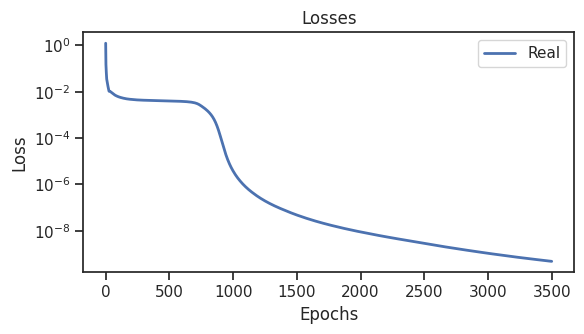

In [ ]:
# %%

## Save results: T, traj_length, losses, thetas, wall_time into a .npz file
np.savez(savepath, time_horizon_init=T, time_horizon_list=T_hrz_list, traj_length=traj_length, losses=losses, thetas=thetas, wall_time=wall_time, grad_norms=grad_norms)

sbplot(losses, "-", label="Real", y_scale="log", title="Losses", x_label="Epochs", y_label="Loss");

In [ ]:
# %%

# ## Test 3: Plot to training predictions
# X_full, t_full = batch
# t_eval_small = np.linspace(0, T_hrz.T, traj_length)

# X, _ = model_real(X_full, t_full, T_hrz.T)
# X_hat, _ = model(X_full[...,0,:], T_hrz.T)

# ax = sbplot(t_eval_small, X_hat[0, :, 0], "-", label="Predicted", title="Real vs Predicted", x_label="Time", y_label="Position")
# ax = sbplot(t_eval_small, X[0, :, 0], "x", label="Real", ax=ax)

In [ ]:
import jax
import jax.numpy as jnp
import numpy as np
from scipy.integrate import solve_ivp
import equinox as eqx
import diffrax
import optax
import time
import argparse

from neuralhub import params_norm, params_norm_squared, sbplot, RK4

try:
    __IPYTHON__
    _in_ipython_session = True
except NameError:
    _in_ipython_session = False


#%%

if _in_ipython_session:
	# args = argparse.Namespace(time_horizon='39.396473', savepath="results_sgd_9/99999.npz", verbose=1)
	args = argparse.Namespace(time_horizon='15.0', savepath="results_sgd_9/99999.npz", verbose=1)
else:
	parser = argparse.ArgumentParser(description='Description of your program')
	parser.add_argument('--time_horizon', type=str, help='Time Horizon T', default='10.00', required=False)
	parser.add_argument('--savepath', type=str, help='Save the results to', default='results/99999.npz', required=False)
	parser.add_argument('--verbose',type=int, help='Whether to print details or not ?', default=1, required=False)
	args = parser.parse_args()

T = float(args.time_horizon)
savepath = args.savepath
verbose = args.verbose

if verbose:
    print("\n############# Lotka-Volterra with Neural ODE #############\n")
    print("  - Initial time Horizon T: ", T)
    print("  - Savepath: ", savepath)

## Training hps
print_every = 300
nb_epochs = 3500
init_lr_mod = 1e-1
init_lr_T = 10.

traj_length = 25
skip_steps = 1

T_full = 100        ### All trajectories are this long, just in case !


############# Lotka-Volterra with Neural ODE #############

  - Initial time Horizon T:  15.0
  - Savepath:  results_sgd_9/99999.npz


In [ ]:
#%%

def mass_spring_damper(t, state, k, mu, m):
    E = np.array([[0, 1], [-k/m, -mu/m]])
    return E @ state

p = {"k": 1, "mu": 0.25, "m": 1}
t_eval_full = np.linspace(0, T_full, (traj_length-1)*100+1)[::skip_steps]  ## Biggest t we can find !
initial_state = [1.0, 1.0]

solution = solve_ivp(mass_spring_damper, (0,T_full), initial_state, args=p.values(), t_eval=t_eval_full)
data = solution.y.T[None, None, ::, :]

# ## Test 0: Plot the data
# sbplot(t_eval_full, data[0, 0, :, 0], title="Mass-Spring-Damper: Position", x_label="Time", y_label="Position");

# ## Test 1: Plot the interpolation as well
# t_eval_small = np.linspace(0, T, traj_length)
# sol_int = np.interp(t_eval_small, t_eval_full, data[0, 0, :, 0])
# ax = sbplot(t_eval_small, sol_int, "-", title="Interpolation vs Renormalisation", x_label="Time", y_label="Position", label="Interpolated");

# ## Test 2: Integrate a renomalized vector field
# def mass_spring_damper_renormed(t, state, k, mu, m):
#     E = np.array([[0, 1], [-k/m, -mu/m]])
#     return T * (E @ state)
# t_renormed = np.linspace(0, 1, traj_length)
# sol_renormed = solve_ivp(mass_spring_damper_renormed, (0,1), initial_state, args=p.values(), t_eval=t_renormed)
# ax = sbplot(t_eval_small, sol_renormed.y[0], "x", label="Renormalized", y_label="Position", ax=ax);

In [ ]:
# %%

class Processor(eqx.Module):
    matrix: jnp.ndarray

    def __init__(self, in_size, out_size, key=None):
        self.matrix = jnp.array([[0., 0.], [0., 0.]])

    def __call__(self, t, x, args):
        T = args[0]
        return T * (self.matrix @ x)


class NeuralODE(eqx.Module):
    data_size: int
    vector_field: eqx.Module

    def __init__(self, data_size, key=None):
        self.data_size = data_size
        self.vector_field = Processor(data_size, data_size, key=key)

    def __call__(self, x0s, T):
        t_eval = jnp.linspace(0,1,traj_length)

        def integrate(y0):
            # sol = diffrax.diffeqsolve(
            #         diffrax.ODETerm(self.vector_field),
            #         diffrax.Tsit5(),
            #         t0=t_eval[0],
            #         t1=t_eval[-1],
            #         args=(T,),
            #         dt0=1e-3,
            #         y0=y0,
            #         stepsize_controller=diffrax.PIDController(rtol=1e-3, atol=1e-6),
            #         saveat=diffrax.SaveAt(ts=t_eval),
            #         # adjoint=diffrax.BacksolveAdjoint(),
            #         adjoint=diffrax.RecursiveCheckpointAdjoint(),
            #         max_steps=4096
            #     )
            # return sol.ys, sol.stats["num_steps"]

            sol = RK4(fun=self.vector_field, 
                      t_span=(t_eval[0], t_eval[-1]), 
                      y0=y0,
                      args=(T,T, T),
                      t_eval=t_eval, 
                      subdivisions=5)
            return sol, t_eval.shape[0]*5

        trajs, nb_fes = eqx.filter_vmap(integrate)(x0s)
        return trajs, jnp.sum(nb_fes)


def model_real(X_full, t_full, T):
    t_eval = jnp.linspace(0, T, traj_length)

    ## Interpolate X_full to t_eval
    X1 = jnp.interp(t_eval, t_full, X_full[0, ...,0])
    X2 = jnp.interp(t_eval, t_full, X_full[0, ...,1])

    return jnp.concatenate([X1, X2], axis=-1)[None,...], t_eval







class THorizon(eqx.Module):
    T: jnp.ndarray

    def __init__(self, init_T, key=None):
        self.T = jnp.array([init_T])

    def __call__(self):
        return self.T


model = NeuralODE(data_size=2)
T_hrz = THorizon(T)
mega_model = (model, T_hrz)

# model_real(jnp.array([1., 1.])[None, ...], T)
# print(data[0, :, 0].shape)
# model_real(data[:, :, 0], T)

In [ ]:
# %%

def loss_fn(mega_model, batch):
    model, T_hrz = mega_model
    X_full, t_full = batch
    X, _ = model_real(X_full, t_full, T_hrz.T)
    X_hat, _ = model(X_full[...,0,:], T_hrz.T)
    return jnp.mean((X - X_hat)**2)


@eqx.filter_jit
def mega_train_step(mega_model, batch, mega_opt_state):
    loss, mega_grads = eqx.filter_value_and_grad(loss_fn)(mega_model, batch)

    model, T_hrz = mega_model
    grads_mod, grads_T = mega_grads
    opt_state_mod, opt_state_T = mega_opt_state

    updates, opt_state_mod = opt_mod.update(grads_mod, opt_state_mod)
    model = eqx.apply_updates(model, updates)

    grad_norm = params_norm(grads_mod)
    # grad_norm = params_norm_squared(grads_mod)

    ## Only update T if the gradient norm if we are at bad saddle point (hessian has small eigenvalues) ##
    hessians = eqx.filter_hessian(loss_fn)(mega_model, batch)
    # jax.debug.print("hessians {}", hessians)
    hess_theta = hessians[0].vector_field.matrix[0].vector_field.matrix.reshape((4,4))
    eigvals = jnp.linalg.eigh(hess_theta)[0]
    # jax.debug.print("Eigenvalues: {}", eigvals)

    grads_T = jax.lax.cond(jnp.any(jnp.abs(eigvals)<1e-4), 
                            lambda y: jax.tree.map(lambda x: -x, y), 
                            lambda y: jax.tree.map(lambda x: jnp.zeros_like(x), y),
                            grads_T)
    updates, opt_state_T = opt_T.update(grads_T, opt_state_T)
    T_hrz = eqx.apply_updates(T_hrz, updates)

    return (model, T_hrz), (opt_state_mod, opt_state_T), loss, grad_norm



# @eqx.filter_jit
# def mega_train_step_fine(mega_model, batch, mega_opt_state):
#     loss, mega_grads = eqx.filter_value_and_grad(loss_fn)(mega_model, batch)

#     model, T_hrz = mega_model
#     grads_mod, grads_T = mega_grads
#     opt_state_mod, opt_state_T = mega_opt_state

#     updates, opt_state_mod = opt_mod.update(grads_mod, opt_state_mod)
#     model = eqx.apply_updates(model, updates)

#     grad_norm = params_norm(grads_mod)
#     # grad_norm = params_norm_squared(grads_mod)

#     ## Only update T if the gradient norm if we are at bad saddle point (hessian has small eigenvalues) ##
#     hessians = eqx.filter_hessian(loss_fn)(mega_model, batch)
#     # jax.debug.print("hessians {}", hessians)
#     hess_theta = hessians[0].vector_field.matrix[0].vector_field.matrix.reshape((4,4))
#     eigvals = jnp.linalg.eigh(hess_theta)[0]
#     # jax.debug.print("Eigenvalues: {}", eigvals)

#     grads_T = jax.lax.cond(jnp.any(jnp.abs(eigvals)<1e-1), 
#                             lambda y: jax.tree.map(lambda x: x, y), 
#                             lambda y: jax.tree.map(lambda x: jnp.zeros_like(x), y),
#                             grads_T)
#     updates, opt_state_T = opt_T.update(grads_T, opt_state_T)
#     T_hrz = eqx.apply_updates(T_hrz, updates)

#     return (model, T_hrz), (opt_state_mod, opt_state_T), loss, grad_norm



opt_mod = optax.adam(init_lr_mod)
opt_state_mod = opt_mod.init(eqx.filter(model, eqx.is_array))

opt_T = optax.adam(init_lr_T)
opt_state_T = opt_T.init(T_hrz)


if verbose:
    print("\n\n=== Beginning Training ... ===")

start_time = time.time()


losses = []
grad_norms = []
theta_list = [model.vector_field.matrix]
T_hrz_list = [T_hrz.T]

batch = data[0, :, :, :], t_eval_full

for epoch in range(nb_epochs):

    mega_model, opt_states, loss, grad_norm = mega_train_step((model, T_hrz), batch, (opt_state_mod, opt_state_T))

    model, T_hrz = mega_model
    opt_state_mod, opt_state_T = opt_states

    losses.append(loss)
    theta_list.append(model.vector_field.matrix)
    grad_norms.append(grad_norm)
    T_hrz_list.append(T_hrz.T)

    if verbose and (epoch%print_every==0 or epoch==nb_epochs-1):
        print(f"    Epoch: {epoch:-5d}      Loss: {loss:.12f}", flush=True)


# for epoch_fine in range(nb_epochs):

#     mega_model, opt_states, loss, grad_norm = mega_train_step_fine((model, T_hrz), batch, (opt_state_mod, opt_state_T))

#     model, T_hrz = mega_model
#     opt_state_mod, opt_state_T = opt_states

#     if verbose and (epoch_fine%print_every==0 or epoch_fine==nb_epochs-1):
#         print(f"    EpochFine: {epoch_fine:-5d}      Loss: {loss:.12f}", flush=True)



losses = jnp.stack(losses)
thetas = jnp.stack(theta_list)
grad_norms = jnp.stack(grad_norms)
T_hrz_list = jnp.stack(T_hrz_list)

wall_time = time.time() - start_time

if verbose:
    print("\nTotal GD training time: %d secs\n" %wall_time, flush=True)
    print("Final model matrix: \n", model.vector_field.matrix)
    print("Final T: ", T_hrz.T)



=== Beginning Training ... ===
    Epoch:     0      Loss: 1.238064050674
    Epoch:   300      Loss: 0.955092132092
    Epoch:   600      Loss: 0.955089330673
    Epoch:   900      Loss: 0.955085337162
    Epoch:  1200      Loss: 0.955080211163
    Epoch:  1500      Loss: 0.955073893070
    Epoch:  1800      Loss: 0.955066204071
    Epoch:  2100      Loss: 0.955244719982
    Epoch:  2400      Loss: 0.957663655281
    Epoch:  2700      Loss: 0.959151744843
    Epoch:  3000      Loss: 0.959518551826
    Epoch:  3300      Loss: 0.959663391113
    Epoch:  3499      Loss: 0.959672689438

Total GD training time: 26 secs

Final model matrix: 
 [[0.5146234  0.5148697 ]
 [0.51491183 0.5151668 ]]
Final T:  [-133.04451]


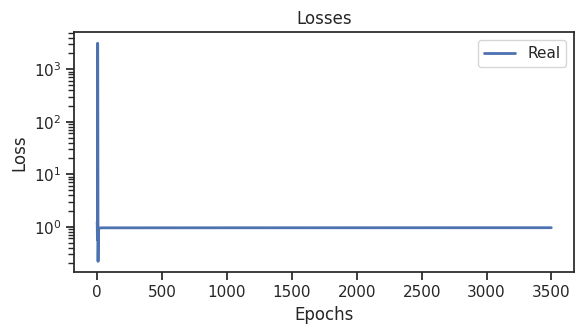

In [ ]:
# %%

## Save results: T, traj_length, losses, thetas, wall_time into a .npz file
np.savez(savepath, time_horizon_init=T, time_horizon_list=T_hrz_list, traj_length=traj_length, losses=losses, thetas=thetas, wall_time=wall_time, grad_norms=grad_norms)

sbplot(losses, "-", label="Real", y_scale="log", title="Losses", x_label="Epochs", y_label="Loss");

In [ ]:
# %%

# ## Test 3: Plot to training predictions
# X_full, t_full = batch
# t_eval_small = np.linspace(0, T_hrz.T, traj_length)

# X, _ = model_real(X_full, t_full, T_hrz.T)
# X_hat, _ = model(X_full[...,0,:], T_hrz.T)

# ax = sbplot(t_eval_small, X_hat[0, :, 0], "-", label="Predicted", title="Real vs Predicted", x_label="Time", y_label="Position")
# ax = sbplot(t_eval_small, X[0, :, 0], "x", label="Real", ax=ax)

In [ ]:
import jax
import jax.numpy as jnp
import numpy as np
from scipy.integrate import solve_ivp
import equinox as eqx
import diffrax
import optax
import time
import argparse

from neuralhub import params_norm, params_norm_squared, sbplot, RK4

try:
    __IPYTHON__
    _in_ipython_session = True
except NameError:
    _in_ipython_session = False


#%%

if _in_ipython_session:
	# args = argparse.Namespace(time_horizon='39.396473', savepath="results_sgd_9/99999.npz", verbose=1)
	args = argparse.Namespace(time_horizon='15.0', savepath="results_sgd_9/99999.npz", verbose=1)
else:
	parser = argparse.ArgumentParser(description='Description of your program')
	parser.add_argument('--time_horizon', type=str, help='Time Horizon T', default='10.00', required=False)
	parser.add_argument('--savepath', type=str, help='Save the results to', default='results/99999.npz', required=False)
	parser.add_argument('--verbose',type=int, help='Whether to print details or not ?', default=1, required=False)
	args = parser.parse_args()

T = float(args.time_horizon)
savepath = args.savepath
verbose = args.verbose

if verbose:
    print("\n############# Lotka-Volterra with Neural ODE #############\n")
    print("  - Initial time Horizon T: ", T)
    print("  - Savepath: ", savepath)

## Training hps
print_every = 300
nb_epochs = 3500
init_lr_mod = 1e-1
init_lr_T = 10.

traj_length = 25
skip_steps = 1

T_full = 100        ### All trajectories are this long, just in case !


############# Lotka-Volterra with Neural ODE #############

  - Initial time Horizon T:  15.0
  - Savepath:  results_sgd_9/99999.npz


In [ ]:
#%%

def mass_spring_damper(t, state, k, mu, m):
    E = np.array([[0, 1], [-k/m, -mu/m]])
    return E @ state

p = {"k": 1, "mu": 0.25, "m": 1}
t_eval_full = np.linspace(0, T_full, (traj_length-1)*100+1)[::skip_steps]  ## Biggest t we can find !
initial_state = [1.0, 1.0]

solution = solve_ivp(mass_spring_damper, (0,T_full), initial_state, args=p.values(), t_eval=t_eval_full)
data = solution.y.T[None, None, ::, :]

# ## Test 0: Plot the data
# sbplot(t_eval_full, data[0, 0, :, 0], title="Mass-Spring-Damper: Position", x_label="Time", y_label="Position");

# ## Test 1: Plot the interpolation as well
# t_eval_small = np.linspace(0, T, traj_length)
# sol_int = np.interp(t_eval_small, t_eval_full, data[0, 0, :, 0])
# ax = sbplot(t_eval_small, sol_int, "-", title="Interpolation vs Renormalisation", x_label="Time", y_label="Position", label="Interpolated");

# ## Test 2: Integrate a renomalized vector field
# def mass_spring_damper_renormed(t, state, k, mu, m):
#     E = np.array([[0, 1], [-k/m, -mu/m]])
#     return T * (E @ state)
# t_renormed = np.linspace(0, 1, traj_length)
# sol_renormed = solve_ivp(mass_spring_damper_renormed, (0,1), initial_state, args=p.values(), t_eval=t_renormed)
# ax = sbplot(t_eval_small, sol_renormed.y[0], "x", label="Renormalized", y_label="Position", ax=ax);

In [ ]:
# %%

class Processor(eqx.Module):
    matrix: jnp.ndarray

    def __init__(self, in_size, out_size, key=None):
        self.matrix = jnp.array([[0., 0.], [0., 0.]])

    def __call__(self, t, x, args):
        T = args[0]
        return T * (self.matrix @ x)


class NeuralODE(eqx.Module):
    data_size: int
    vector_field: eqx.Module

    def __init__(self, data_size, key=None):
        self.data_size = data_size
        self.vector_field = Processor(data_size, data_size, key=key)

    def __call__(self, x0s, T):
        t_eval = jnp.linspace(0,1,traj_length)

        def integrate(y0):
            # sol = diffrax.diffeqsolve(
            #         diffrax.ODETerm(self.vector_field),
            #         diffrax.Tsit5(),
            #         t0=t_eval[0],
            #         t1=t_eval[-1],
            #         args=(T,),
            #         dt0=1e-3,
            #         y0=y0,
            #         stepsize_controller=diffrax.PIDController(rtol=1e-3, atol=1e-6),
            #         saveat=diffrax.SaveAt(ts=t_eval),
            #         # adjoint=diffrax.BacksolveAdjoint(),
            #         adjoint=diffrax.RecursiveCheckpointAdjoint(),
            #         max_steps=4096
            #     )
            # return sol.ys, sol.stats["num_steps"]

            sol = RK4(fun=self.vector_field, 
                      t_span=(t_eval[0], t_eval[-1]), 
                      y0=y0,
                      args=(T,T, T),
                      t_eval=t_eval, 
                      subdivisions=5)
            return sol, t_eval.shape[0]*5

        trajs, nb_fes = eqx.filter_vmap(integrate)(x0s)
        return trajs, jnp.sum(nb_fes)


def model_real(X_full, t_full, T):
    t_eval = jnp.linspace(0, T, traj_length)

    ## Interpolate X_full to t_eval
    X1 = jnp.interp(t_eval, t_full, X_full[0, ...,0])
    X2 = jnp.interp(t_eval, t_full, X_full[0, ...,1])

    return jnp.concatenate([X1, X2], axis=-1)[None,...], t_eval







class THorizon(eqx.Module):
    T: jnp.ndarray

    def __init__(self, init_T, key=None):
        self.T = jnp.array([init_T])

    def __call__(self):
        return self.T


model = NeuralODE(data_size=2)
T_hrz = THorizon(T)
mega_model = (model, T_hrz)

# model_real(jnp.array([1., 1.])[None, ...], T)
# print(data[0, :, 0].shape)
# model_real(data[:, :, 0], T)

In [ ]:
# %%

def loss_fn(mega_model, batch):
    model, T_hrz = mega_model
    X_full, t_full = batch
    X, _ = model_real(X_full, t_full, T_hrz.T)
    X_hat, _ = model(X_full[...,0,:], T_hrz.T)
    return jnp.mean((X - X_hat)**2)


@eqx.filter_jit
def mega_train_step(mega_model, batch, mega_opt_state):
    loss, mega_grads = eqx.filter_value_and_grad(loss_fn)(mega_model, batch)

    model, T_hrz = mega_model
    grads_mod, grads_T = mega_grads
    opt_state_mod, opt_state_T = mega_opt_state

    updates, opt_state_mod = opt_mod.update(grads_mod, opt_state_mod)
    model = eqx.apply_updates(model, updates)

    grad_norm = params_norm(grads_mod)
    # grad_norm = params_norm_squared(grads_mod)

    ## Only update T if the gradient norm if we are at bad saddle point (hessian has small eigenvalues) ##
    hessians = eqx.filter_hessian(loss_fn)(mega_model, batch)
    # jax.debug.print("hessians {}", hessians)
    hess_theta = hessians[0].vector_field.matrix[0].vector_field.matrix.reshape((4,4))
    eigvals = jnp.linalg.eigh(hess_theta)[0]
    # jax.debug.print("Eigenvalues: {}", eigvals)

    grads_T = jax.lax.cond(jnp.any(jnp.abs(eigvals)<1e2), 
                            lambda y: jax.tree.map(lambda x: -x, y), 
                            lambda y: jax.tree.map(lambda x: jnp.zeros_like(x), y),
                            grads_T)
    updates, opt_state_T = opt_T.update(grads_T, opt_state_T)
    T_hrz = eqx.apply_updates(T_hrz, updates)

    return (model, T_hrz), (opt_state_mod, opt_state_T), loss, grad_norm



# @eqx.filter_jit
# def mega_train_step_fine(mega_model, batch, mega_opt_state):
#     loss, mega_grads = eqx.filter_value_and_grad(loss_fn)(mega_model, batch)

#     model, T_hrz = mega_model
#     grads_mod, grads_T = mega_grads
#     opt_state_mod, opt_state_T = mega_opt_state

#     updates, opt_state_mod = opt_mod.update(grads_mod, opt_state_mod)
#     model = eqx.apply_updates(model, updates)

#     grad_norm = params_norm(grads_mod)
#     # grad_norm = params_norm_squared(grads_mod)

#     ## Only update T if the gradient norm if we are at bad saddle point (hessian has small eigenvalues) ##
#     hessians = eqx.filter_hessian(loss_fn)(mega_model, batch)
#     # jax.debug.print("hessians {}", hessians)
#     hess_theta = hessians[0].vector_field.matrix[0].vector_field.matrix.reshape((4,4))
#     eigvals = jnp.linalg.eigh(hess_theta)[0]
#     # jax.debug.print("Eigenvalues: {}", eigvals)

#     grads_T = jax.lax.cond(jnp.any(jnp.abs(eigvals)<1e-1), 
#                             lambda y: jax.tree.map(lambda x: x, y), 
#                             lambda y: jax.tree.map(lambda x: jnp.zeros_like(x), y),
#                             grads_T)
#     updates, opt_state_T = opt_T.update(grads_T, opt_state_T)
#     T_hrz = eqx.apply_updates(T_hrz, updates)

#     return (model, T_hrz), (opt_state_mod, opt_state_T), loss, grad_norm



opt_mod = optax.adam(init_lr_mod)
opt_state_mod = opt_mod.init(eqx.filter(model, eqx.is_array))

opt_T = optax.adam(init_lr_T)
opt_state_T = opt_T.init(T_hrz)


if verbose:
    print("\n\n=== Beginning Training ... ===")

start_time = time.time()


losses = []
grad_norms = []
theta_list = [model.vector_field.matrix]
T_hrz_list = [T_hrz.T]

batch = data[0, :, :, :], t_eval_full

for epoch in range(nb_epochs):

    mega_model, opt_states, loss, grad_norm = mega_train_step((model, T_hrz), batch, (opt_state_mod, opt_state_T))

    model, T_hrz = mega_model
    opt_state_mod, opt_state_T = opt_states

    losses.append(loss)
    theta_list.append(model.vector_field.matrix)
    grad_norms.append(grad_norm)
    T_hrz_list.append(T_hrz.T)

    if verbose and (epoch%print_every==0 or epoch==nb_epochs-1):
        print(f"    Epoch: {epoch:-5d}      Loss: {loss:.12f}", flush=True)


# for epoch_fine in range(nb_epochs):

#     mega_model, opt_states, loss, grad_norm = mega_train_step_fine((model, T_hrz), batch, (opt_state_mod, opt_state_T))

#     model, T_hrz = mega_model
#     opt_state_mod, opt_state_T = opt_states

#     if verbose and (epoch_fine%print_every==0 or epoch_fine==nb_epochs-1):
#         print(f"    EpochFine: {epoch_fine:-5d}      Loss: {loss:.12f}", flush=True)



losses = jnp.stack(losses)
thetas = jnp.stack(theta_list)
grad_norms = jnp.stack(grad_norms)
T_hrz_list = jnp.stack(T_hrz_list)

wall_time = time.time() - start_time

if verbose:
    print("\nTotal GD training time: %d secs\n" %wall_time, flush=True)
    print("Final model matrix: \n", model.vector_field.matrix)
    print("Final T: ", T_hrz.T)



=== Beginning Training ... ===
    Epoch:     0      Loss: 1.238064050674
    Epoch:   300      Loss: 0.958888888359
    Epoch:   600      Loss: 0.958888709545
    Epoch:   900      Loss: 0.958888530731
    Epoch:  1200      Loss: 0.958888232708
    Epoch:  1500      Loss: 0.958887815475
    Epoch:  1800      Loss: 0.958887398243
    Epoch:  2100      Loss: 0.958886861801
    Epoch:  2400      Loss: 0.958886265755
    Epoch:  2700      Loss: 0.958885550499
    Epoch:  3000      Loss: 0.958884716034
    Epoch:  3300      Loss: 0.958883821964
    Epoch:  3499      Loss: 0.958883047104

Total GD training time: 26 secs

Final model matrix: 
 [[0.5860842  0.5862449 ]
 [0.58634204 0.58652043]]
Final T:  [-88.41701]


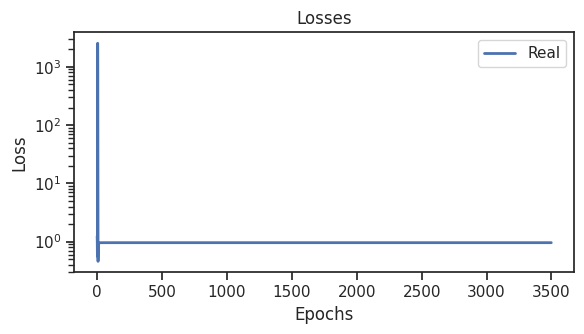

In [ ]:
# %%

## Save results: T, traj_length, losses, thetas, wall_time into a .npz file
np.savez(savepath, time_horizon_init=T, time_horizon_list=T_hrz_list, traj_length=traj_length, losses=losses, thetas=thetas, wall_time=wall_time, grad_norms=grad_norms)

sbplot(losses, "-", label="Real", y_scale="log", title="Losses", x_label="Epochs", y_label="Loss");

In [ ]:
# %%

# ## Test 3: Plot to training predictions
# X_full, t_full = batch
# t_eval_small = np.linspace(0, T_hrz.T, traj_length)

# X, _ = model_real(X_full, t_full, T_hrz.T)
# X_hat, _ = model(X_full[...,0,:], T_hrz.T)

# ax = sbplot(t_eval_small, X_hat[0, :, 0], "-", label="Predicted", title="Real vs Predicted", x_label="Time", y_label="Position")
# ax = sbplot(t_eval_small, X[0, :, 0], "x", label="Real", ax=ax)

In [ ]:
import jax
import jax.numpy as jnp
import numpy as np
from scipy.integrate import solve_ivp
import equinox as eqx
import diffrax
import optax
import time
import argparse

from neuralhub import params_norm, params_norm_squared, sbplot, RK4

try:
    __IPYTHON__
    _in_ipython_session = True
except NameError:
    _in_ipython_session = False


#%%

if _in_ipython_session:
	# args = argparse.Namespace(time_horizon='39.396473', savepath="results_sgd_9/99999.npz", verbose=1)
	args = argparse.Namespace(time_horizon='15.0', savepath="results_sgd_9/99999.npz", verbose=1)
else:
	parser = argparse.ArgumentParser(description='Description of your program')
	parser.add_argument('--time_horizon', type=str, help='Time Horizon T', default='10.00', required=False)
	parser.add_argument('--savepath', type=str, help='Save the results to', default='results/99999.npz', required=False)
	parser.add_argument('--verbose',type=int, help='Whether to print details or not ?', default=1, required=False)
	args = parser.parse_args()

T = float(args.time_horizon)
savepath = args.savepath
verbose = args.verbose

if verbose:
    print("\n############# Lotka-Volterra with Neural ODE #############\n")
    print("  - Initial time Horizon T: ", T)
    print("  - Savepath: ", savepath)

## Training hps
print_every = 300
nb_epochs = 3500
init_lr_mod = 1e-1
init_lr_T = 10.

traj_length = 25
skip_steps = 1

T_full = 100        ### All trajectories are this long, just in case !


############# Lotka-Volterra with Neural ODE #############

  - Initial time Horizon T:  15.0
  - Savepath:  results_sgd_9/99999.npz


In [ ]:
#%%

def mass_spring_damper(t, state, k, mu, m):
    E = np.array([[0, 1], [-k/m, -mu/m]])
    return E @ state

p = {"k": 1, "mu": 0.25, "m": 1}
t_eval_full = np.linspace(0, T_full, (traj_length-1)*100+1)[::skip_steps]  ## Biggest t we can find !
initial_state = [1.0, 1.0]

solution = solve_ivp(mass_spring_damper, (0,T_full), initial_state, args=p.values(), t_eval=t_eval_full)
data = solution.y.T[None, None, ::, :]

# ## Test 0: Plot the data
# sbplot(t_eval_full, data[0, 0, :, 0], title="Mass-Spring-Damper: Position", x_label="Time", y_label="Position");

# ## Test 1: Plot the interpolation as well
# t_eval_small = np.linspace(0, T, traj_length)
# sol_int = np.interp(t_eval_small, t_eval_full, data[0, 0, :, 0])
# ax = sbplot(t_eval_small, sol_int, "-", title="Interpolation vs Renormalisation", x_label="Time", y_label="Position", label="Interpolated");

# ## Test 2: Integrate a renomalized vector field
# def mass_spring_damper_renormed(t, state, k, mu, m):
#     E = np.array([[0, 1], [-k/m, -mu/m]])
#     return T * (E @ state)
# t_renormed = np.linspace(0, 1, traj_length)
# sol_renormed = solve_ivp(mass_spring_damper_renormed, (0,1), initial_state, args=p.values(), t_eval=t_renormed)
# ax = sbplot(t_eval_small, sol_renormed.y[0], "x", label="Renormalized", y_label="Position", ax=ax);

In [ ]:
# %%

class Processor(eqx.Module):
    matrix: jnp.ndarray

    def __init__(self, in_size, out_size, key=None):
        self.matrix = jnp.array([[0., 0.], [0., 0.]])

    def __call__(self, t, x, args):
        T = args[0]
        return T * (self.matrix @ x)


class NeuralODE(eqx.Module):
    data_size: int
    vector_field: eqx.Module

    def __init__(self, data_size, key=None):
        self.data_size = data_size
        self.vector_field = Processor(data_size, data_size, key=key)

    def __call__(self, x0s, T):
        t_eval = jnp.linspace(0,1,traj_length)

        def integrate(y0):
            # sol = diffrax.diffeqsolve(
            #         diffrax.ODETerm(self.vector_field),
            #         diffrax.Tsit5(),
            #         t0=t_eval[0],
            #         t1=t_eval[-1],
            #         args=(T,),
            #         dt0=1e-3,
            #         y0=y0,
            #         stepsize_controller=diffrax.PIDController(rtol=1e-3, atol=1e-6),
            #         saveat=diffrax.SaveAt(ts=t_eval),
            #         # adjoint=diffrax.BacksolveAdjoint(),
            #         adjoint=diffrax.RecursiveCheckpointAdjoint(),
            #         max_steps=4096
            #     )
            # return sol.ys, sol.stats["num_steps"]

            sol = RK4(fun=self.vector_field, 
                      t_span=(t_eval[0], t_eval[-1]), 
                      y0=y0,
                      args=(T,T, T),
                      t_eval=t_eval, 
                      subdivisions=5)
            return sol, t_eval.shape[0]*5

        trajs, nb_fes = eqx.filter_vmap(integrate)(x0s)
        return trajs, jnp.sum(nb_fes)


def model_real(X_full, t_full, T):
    t_eval = jnp.linspace(0, T, traj_length)

    ## Interpolate X_full to t_eval
    X1 = jnp.interp(t_eval, t_full, X_full[0, ...,0])
    X2 = jnp.interp(t_eval, t_full, X_full[0, ...,1])

    return jnp.concatenate([X1, X2], axis=-1)[None,...], t_eval







class THorizon(eqx.Module):
    T: jnp.ndarray

    def __init__(self, init_T, key=None):
        self.T = jnp.array([init_T])

    def __call__(self):
        return self.T


model = NeuralODE(data_size=2)
T_hrz = THorizon(T)
mega_model = (model, T_hrz)

# model_real(jnp.array([1., 1.])[None, ...], T)
# print(data[0, :, 0].shape)
# model_real(data[:, :, 0], T)

In [ ]:
# %%

def loss_fn(mega_model, batch):
    model, T_hrz = mega_model
    X_full, t_full = batch
    X, _ = model_real(X_full, t_full, T_hrz.T)
    X_hat, _ = model(X_full[...,0,:], T_hrz.T)
    return jnp.mean((X - X_hat)**2)


@eqx.filter_jit
def mega_train_step(mega_model, batch, mega_opt_state):
    loss, mega_grads = eqx.filter_value_and_grad(loss_fn)(mega_model, batch)

    model, T_hrz = mega_model
    grads_mod, grads_T = mega_grads
    opt_state_mod, opt_state_T = mega_opt_state

    updates, opt_state_mod = opt_mod.update(grads_mod, opt_state_mod)
    model = eqx.apply_updates(model, updates)

    grad_norm = params_norm(grads_mod)
    # grad_norm = params_norm_squared(grads_mod)

    ## Only update T if the gradient norm if we are at bad saddle point (hessian has small eigenvalues) ##
    hessians = eqx.filter_hessian(loss_fn)(mega_model, batch)
    # jax.debug.print("hessians {}", hessians)
    hess_theta = hessians[0].vector_field.matrix[0].vector_field.matrix.reshape((4,4))
    eigvals = jnp.linalg.eigh(hess_theta)[0]
    # jax.debug.print("Eigenvalues: {}", eigvals)

    grads_T = jax.lax.cond(jnp.any(jnp.abs(eigvals)<1e-1), 
                            lambda y: jax.tree.map(lambda x: -x, y), 
                            lambda y: jax.tree.map(lambda x: jnp.zeros_like(x), y),
                            grads_T)
    updates, opt_state_T = opt_T.update(grads_T, opt_state_T)
    T_hrz = eqx.apply_updates(T_hrz, updates)

    return (model, T_hrz), (opt_state_mod, opt_state_T), loss, grad_norm



# @eqx.filter_jit
# def mega_train_step_fine(mega_model, batch, mega_opt_state):
#     loss, mega_grads = eqx.filter_value_and_grad(loss_fn)(mega_model, batch)

#     model, T_hrz = mega_model
#     grads_mod, grads_T = mega_grads
#     opt_state_mod, opt_state_T = mega_opt_state

#     updates, opt_state_mod = opt_mod.update(grads_mod, opt_state_mod)
#     model = eqx.apply_updates(model, updates)

#     grad_norm = params_norm(grads_mod)
#     # grad_norm = params_norm_squared(grads_mod)

#     ## Only update T if the gradient norm if we are at bad saddle point (hessian has small eigenvalues) ##
#     hessians = eqx.filter_hessian(loss_fn)(mega_model, batch)
#     # jax.debug.print("hessians {}", hessians)
#     hess_theta = hessians[0].vector_field.matrix[0].vector_field.matrix.reshape((4,4))
#     eigvals = jnp.linalg.eigh(hess_theta)[0]
#     # jax.debug.print("Eigenvalues: {}", eigvals)

#     grads_T = jax.lax.cond(jnp.any(jnp.abs(eigvals)<1e-1), 
#                             lambda y: jax.tree.map(lambda x: x, y), 
#                             lambda y: jax.tree.map(lambda x: jnp.zeros_like(x), y),
#                             grads_T)
#     updates, opt_state_T = opt_T.update(grads_T, opt_state_T)
#     T_hrz = eqx.apply_updates(T_hrz, updates)

#     return (model, T_hrz), (opt_state_mod, opt_state_T), loss, grad_norm



opt_mod = optax.adam(init_lr_mod)
opt_state_mod = opt_mod.init(eqx.filter(model, eqx.is_array))

opt_T = optax.adam(init_lr_T)
opt_state_T = opt_T.init(T_hrz)


if verbose:
    print("\n\n=== Beginning Training ... ===")

start_time = time.time()


losses = []
grad_norms = []
theta_list = [model.vector_field.matrix]
T_hrz_list = [T_hrz.T]

batch = data[0, :, :, :], t_eval_full

for epoch in range(nb_epochs):

    mega_model, opt_states, loss, grad_norm = mega_train_step((model, T_hrz), batch, (opt_state_mod, opt_state_T))

    model, T_hrz = mega_model
    opt_state_mod, opt_state_T = opt_states

    losses.append(loss)
    theta_list.append(model.vector_field.matrix)
    grad_norms.append(grad_norm)
    T_hrz_list.append(T_hrz.T)

    if verbose and (epoch%print_every==0 or epoch==nb_epochs-1):
        print(f"    Epoch: {epoch:-5d}      Loss: {loss:.12f}", flush=True)


# for epoch_fine in range(nb_epochs):

#     mega_model, opt_states, loss, grad_norm = mega_train_step_fine((model, T_hrz), batch, (opt_state_mod, opt_state_T))

#     model, T_hrz = mega_model
#     opt_state_mod, opt_state_T = opt_states

#     if verbose and (epoch_fine%print_every==0 or epoch_fine==nb_epochs-1):
#         print(f"    EpochFine: {epoch_fine:-5d}      Loss: {loss:.12f}", flush=True)



losses = jnp.stack(losses)
thetas = jnp.stack(theta_list)
grad_norms = jnp.stack(grad_norms)
T_hrz_list = jnp.stack(T_hrz_list)

wall_time = time.time() - start_time

if verbose:
    print("\nTotal GD training time: %d secs\n" %wall_time, flush=True)
    print("Final model matrix: \n", model.vector_field.matrix)
    print("Final T: ", T_hrz.T)



=== Beginning Training ... ===
    Epoch:     0      Loss: 1.238064050674
    Epoch:   300      Loss: 0.956395983696
    Epoch:   600      Loss: 0.956396639347
    Epoch:   900      Loss: 0.956397533417
    Epoch:  1200      Loss: 0.956398725510
    Epoch:  1500      Loss: 0.956400275230
    Epoch:  1800      Loss: 0.956402122974
    Epoch:  2100      Loss: 0.956404328346
    Epoch:  2400      Loss: 0.956407010555
    Epoch:  2700      Loss: 0.956410050392
    Epoch:  3000      Loss: 0.956413567066
    Epoch:  3300      Loss: 0.956417500973
    Epoch:  3499      Loss: 0.956420600414

Total GD training time: 26 secs

Final model matrix: 
 [[0.5148477  0.51519084]
 [0.5151492  0.5155038 ]]
Final T:  [-73.07604]


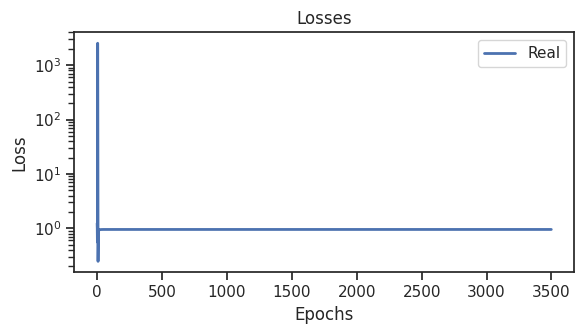

In [ ]:
# %%

## Save results: T, traj_length, losses, thetas, wall_time into a .npz file
np.savez(savepath, time_horizon_init=T, time_horizon_list=T_hrz_list, traj_length=traj_length, losses=losses, thetas=thetas, wall_time=wall_time, grad_norms=grad_norms)

sbplot(losses, "-", label="Real", y_scale="log", title="Losses", x_label="Epochs", y_label="Loss");

In [ ]:
# %%

# ## Test 3: Plot to training predictions
# X_full, t_full = batch
# t_eval_small = np.linspace(0, T_hrz.T, traj_length)

# X, _ = model_real(X_full, t_full, T_hrz.T)
# X_hat, _ = model(X_full[...,0,:], T_hrz.T)

# ax = sbplot(t_eval_small, X_hat[0, :, 0], "-", label="Predicted", title="Real vs Predicted", x_label="Time", y_label="Position")
# ax = sbplot(t_eval_small, X[0, :, 0], "x", label="Real", ax=ax)

In [ ]:
import jax
import jax.numpy as jnp
import numpy as np
from scipy.integrate import solve_ivp
import equinox as eqx
import diffrax
import optax
import time
import argparse

from neuralhub import params_norm, params_norm_squared, sbplot, RK4

try:
    __IPYTHON__
    _in_ipython_session = True
except NameError:
    _in_ipython_session = False


#%%

if _in_ipython_session:
	# args = argparse.Namespace(time_horizon='39.396473', savepath="results_sgd_9/99999.npz", verbose=1)
	args = argparse.Namespace(time_horizon='15.0', savepath="results_sgd_9/99999.npz", verbose=1)
else:
	parser = argparse.ArgumentParser(description='Description of your program')
	parser.add_argument('--time_horizon', type=str, help='Time Horizon T', default='10.00', required=False)
	parser.add_argument('--savepath', type=str, help='Save the results to', default='results/99999.npz', required=False)
	parser.add_argument('--verbose',type=int, help='Whether to print details or not ?', default=1, required=False)
	args = parser.parse_args()

T = float(args.time_horizon)
savepath = args.savepath
verbose = args.verbose

if verbose:
    print("\n############# Lotka-Volterra with Neural ODE #############\n")
    print("  - Initial time Horizon T: ", T)
    print("  - Savepath: ", savepath)

## Training hps
print_every = 300
nb_epochs = 3500
init_lr_mod = 1e-1
init_lr_T = 1e-1

traj_length = 25
skip_steps = 1

T_full = 100        ### All trajectories are this long, just in case !


############# Lotka-Volterra with Neural ODE #############

  - Initial time Horizon T:  15.0
  - Savepath:  results_sgd_9/99999.npz


In [ ]:
#%%

def mass_spring_damper(t, state, k, mu, m):
    E = np.array([[0, 1], [-k/m, -mu/m]])
    return E @ state

p = {"k": 1, "mu": 0.25, "m": 1}
t_eval_full = np.linspace(0, T_full, (traj_length-1)*100+1)[::skip_steps]  ## Biggest t we can find !
initial_state = [1.0, 1.0]

solution = solve_ivp(mass_spring_damper, (0,T_full), initial_state, args=p.values(), t_eval=t_eval_full)
data = solution.y.T[None, None, ::, :]

# ## Test 0: Plot the data
# sbplot(t_eval_full, data[0, 0, :, 0], title="Mass-Spring-Damper: Position", x_label="Time", y_label="Position");

# ## Test 1: Plot the interpolation as well
# t_eval_small = np.linspace(0, T, traj_length)
# sol_int = np.interp(t_eval_small, t_eval_full, data[0, 0, :, 0])
# ax = sbplot(t_eval_small, sol_int, "-", title="Interpolation vs Renormalisation", x_label="Time", y_label="Position", label="Interpolated");

# ## Test 2: Integrate a renomalized vector field
# def mass_spring_damper_renormed(t, state, k, mu, m):
#     E = np.array([[0, 1], [-k/m, -mu/m]])
#     return T * (E @ state)
# t_renormed = np.linspace(0, 1, traj_length)
# sol_renormed = solve_ivp(mass_spring_damper_renormed, (0,1), initial_state, args=p.values(), t_eval=t_renormed)
# ax = sbplot(t_eval_small, sol_renormed.y[0], "x", label="Renormalized", y_label="Position", ax=ax);

In [ ]:
# %%

class Processor(eqx.Module):
    matrix: jnp.ndarray

    def __init__(self, in_size, out_size, key=None):
        self.matrix = jnp.array([[0., 0.], [0., 0.]])

    def __call__(self, t, x, args):
        T = args[0]
        return T * (self.matrix @ x)


class NeuralODE(eqx.Module):
    data_size: int
    vector_field: eqx.Module

    def __init__(self, data_size, key=None):
        self.data_size = data_size
        self.vector_field = Processor(data_size, data_size, key=key)

    def __call__(self, x0s, T):
        t_eval = jnp.linspace(0,1,traj_length)

        def integrate(y0):
            # sol = diffrax.diffeqsolve(
            #         diffrax.ODETerm(self.vector_field),
            #         diffrax.Tsit5(),
            #         t0=t_eval[0],
            #         t1=t_eval[-1],
            #         args=(T,),
            #         dt0=1e-3,
            #         y0=y0,
            #         stepsize_controller=diffrax.PIDController(rtol=1e-3, atol=1e-6),
            #         saveat=diffrax.SaveAt(ts=t_eval),
            #         # adjoint=diffrax.BacksolveAdjoint(),
            #         adjoint=diffrax.RecursiveCheckpointAdjoint(),
            #         max_steps=4096
            #     )
            # return sol.ys, sol.stats["num_steps"]

            sol = RK4(fun=self.vector_field, 
                      t_span=(t_eval[0], t_eval[-1]), 
                      y0=y0,
                      args=(T,T, T),
                      t_eval=t_eval, 
                      subdivisions=5)
            return sol, t_eval.shape[0]*5

        trajs, nb_fes = eqx.filter_vmap(integrate)(x0s)
        return trajs, jnp.sum(nb_fes)


def model_real(X_full, t_full, T):
    t_eval = jnp.linspace(0, T, traj_length)

    ## Interpolate X_full to t_eval
    X1 = jnp.interp(t_eval, t_full, X_full[0, ...,0])
    X2 = jnp.interp(t_eval, t_full, X_full[0, ...,1])

    return jnp.concatenate([X1, X2], axis=-1)[None,...], t_eval







class THorizon(eqx.Module):
    T: jnp.ndarray

    def __init__(self, init_T, key=None):
        self.T = jnp.array([init_T])

    def __call__(self):
        return self.T


model = NeuralODE(data_size=2)
T_hrz = THorizon(T)
mega_model = (model, T_hrz)

# model_real(jnp.array([1., 1.])[None, ...], T)
# print(data[0, :, 0].shape)
# model_real(data[:, :, 0], T)

In [ ]:
# %%

def loss_fn(mega_model, batch):
    model, T_hrz = mega_model
    X_full, t_full = batch
    X, _ = model_real(X_full, t_full, T_hrz.T)
    X_hat, _ = model(X_full[...,0,:], T_hrz.T)
    return jnp.mean((X - X_hat)**2)


@eqx.filter_jit
def mega_train_step(mega_model, batch, mega_opt_state):
    loss, mega_grads = eqx.filter_value_and_grad(loss_fn)(mega_model, batch)

    model, T_hrz = mega_model
    grads_mod, grads_T = mega_grads
    opt_state_mod, opt_state_T = mega_opt_state

    updates, opt_state_mod = opt_mod.update(grads_mod, opt_state_mod)
    model = eqx.apply_updates(model, updates)

    grad_norm = params_norm(grads_mod)
    # grad_norm = params_norm_squared(grads_mod)

    ## Only update T if the gradient norm if we are at bad saddle point (hessian has small eigenvalues) ##
    hessians = eqx.filter_hessian(loss_fn)(mega_model, batch)
    # jax.debug.print("hessians {}", hessians)
    hess_theta = hessians[0].vector_field.matrix[0].vector_field.matrix.reshape((4,4))
    eigvals = jnp.linalg.eigh(hess_theta)[0]
    # jax.debug.print("Eigenvalues: {}", eigvals)

    grads_T = jax.lax.cond(jnp.any(jnp.abs(eigvals)<1e-1), 
                            lambda y: jax.tree.map(lambda x: -x, y), 
                            lambda y: jax.tree.map(lambda x: jnp.zeros_like(x), y),
                            grads_T)
    updates, opt_state_T = opt_T.update(grads_T, opt_state_T)
    T_hrz = eqx.apply_updates(T_hrz, updates)

    return (model, T_hrz), (opt_state_mod, opt_state_T), loss, grad_norm



# @eqx.filter_jit
# def mega_train_step_fine(mega_model, batch, mega_opt_state):
#     loss, mega_grads = eqx.filter_value_and_grad(loss_fn)(mega_model, batch)

#     model, T_hrz = mega_model
#     grads_mod, grads_T = mega_grads
#     opt_state_mod, opt_state_T = mega_opt_state

#     updates, opt_state_mod = opt_mod.update(grads_mod, opt_state_mod)
#     model = eqx.apply_updates(model, updates)

#     grad_norm = params_norm(grads_mod)
#     # grad_norm = params_norm_squared(grads_mod)

#     ## Only update T if the gradient norm if we are at bad saddle point (hessian has small eigenvalues) ##
#     hessians = eqx.filter_hessian(loss_fn)(mega_model, batch)
#     # jax.debug.print("hessians {}", hessians)
#     hess_theta = hessians[0].vector_field.matrix[0].vector_field.matrix.reshape((4,4))
#     eigvals = jnp.linalg.eigh(hess_theta)[0]
#     # jax.debug.print("Eigenvalues: {}", eigvals)

#     grads_T = jax.lax.cond(jnp.any(jnp.abs(eigvals)<1e-1), 
#                             lambda y: jax.tree.map(lambda x: x, y), 
#                             lambda y: jax.tree.map(lambda x: jnp.zeros_like(x), y),
#                             grads_T)
#     updates, opt_state_T = opt_T.update(grads_T, opt_state_T)
#     T_hrz = eqx.apply_updates(T_hrz, updates)

#     return (model, T_hrz), (opt_state_mod, opt_state_T), loss, grad_norm



opt_mod = optax.adam(init_lr_mod)
opt_state_mod = opt_mod.init(eqx.filter(model, eqx.is_array))

opt_T = optax.adam(init_lr_T)
opt_state_T = opt_T.init(T_hrz)


if verbose:
    print("\n\n=== Beginning Training ... ===")

start_time = time.time()


losses = []
grad_norms = []
theta_list = [model.vector_field.matrix]
T_hrz_list = [T_hrz.T]

batch = data[0, :, :, :], t_eval_full

for epoch in range(nb_epochs):

    mega_model, opt_states, loss, grad_norm = mega_train_step((model, T_hrz), batch, (opt_state_mod, opt_state_T))

    model, T_hrz = mega_model
    opt_state_mod, opt_state_T = opt_states

    losses.append(loss)
    theta_list.append(model.vector_field.matrix)
    grad_norms.append(grad_norm)
    T_hrz_list.append(T_hrz.T)

    if verbose and (epoch%print_every==0 or epoch==nb_epochs-1):
        print(f"    Epoch: {epoch:-5d}      Loss: {loss:.12f}", flush=True)


# for epoch_fine in range(nb_epochs):

#     mega_model, opt_states, loss, grad_norm = mega_train_step_fine((model, T_hrz), batch, (opt_state_mod, opt_state_T))

#     model, T_hrz = mega_model
#     opt_state_mod, opt_state_T = opt_states

#     if verbose and (epoch_fine%print_every==0 or epoch_fine==nb_epochs-1):
#         print(f"    EpochFine: {epoch_fine:-5d}      Loss: {loss:.12f}", flush=True)



losses = jnp.stack(losses)
thetas = jnp.stack(theta_list)
grad_norms = jnp.stack(grad_norms)
T_hrz_list = jnp.stack(T_hrz_list)

wall_time = time.time() - start_time

if verbose:
    print("\nTotal GD training time: %d secs\n" %wall_time, flush=True)
    print("Final model matrix: \n", model.vector_field.matrix)
    print("Final T: ", T_hrz.T)



=== Beginning Training ... ===
    Epoch:     0      Loss: 1.238064050674
    Epoch:   300      Loss: 0.000000015486
    Epoch:   600      Loss: 0.000000013650
    Epoch:   900      Loss: 0.000000013650
    Epoch:  1200      Loss: 0.000000013652
    Epoch:  1500      Loss: 0.000000013652
    Epoch:  1800      Loss: 0.000000013650
    Epoch:  2100      Loss: 0.000000013650
    Epoch:  2400      Loss: 0.000000013651
    Epoch:  2700      Loss: 0.000000013651
    Epoch:  3000      Loss: 0.000000013650
    Epoch:  3300      Loss: 0.000000013649
    Epoch:  3499      Loss: 0.000000013649

Total GD training time: 26 secs

Final model matrix: 
 [[-1.5622309e-04  1.0001495e+00]
 [-1.0001599e+00 -2.5022027e-01]]
Final T:  [5.1541414]


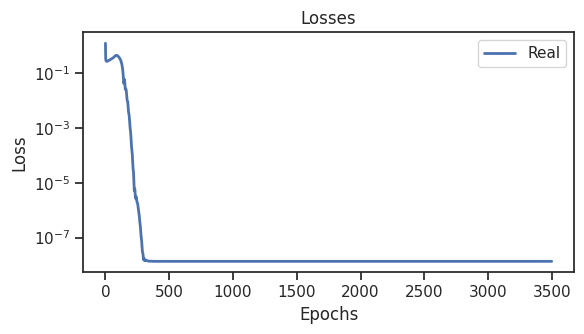

In [ ]:
# %%

## Save results: T, traj_length, losses, thetas, wall_time into a .npz file
np.savez(savepath, time_horizon_init=T, time_horizon_list=T_hrz_list, traj_length=traj_length, losses=losses, thetas=thetas, wall_time=wall_time, grad_norms=grad_norms)

sbplot(losses, "-", label="Real", y_scale="log", title="Losses", x_label="Epochs", y_label="Loss");

In [ ]:
# %%

# ## Test 3: Plot to training predictions
# X_full, t_full = batch
# t_eval_small = np.linspace(0, T_hrz.T, traj_length)

# X, _ = model_real(X_full, t_full, T_hrz.T)
# X_hat, _ = model(X_full[...,0,:], T_hrz.T)

# ax = sbplot(t_eval_small, X_hat[0, :, 0], "-", label="Predicted", title="Real vs Predicted", x_label="Time", y_label="Position")
# ax = sbplot(t_eval_small, X[0, :, 0], "x", label="Real", ax=ax)

In [ ]:
import jax
import jax.numpy as jnp
import numpy as np
from scipy.integrate import solve_ivp
import equinox as eqx
import diffrax
import optax
import time
import argparse

from neuralhub import params_norm, params_norm_squared, sbplot, RK4

try:
    __IPYTHON__
    _in_ipython_session = True
except NameError:
    _in_ipython_session = False


#%%

if _in_ipython_session:
	# args = argparse.Namespace(time_horizon='39.396473', savepath="results_sgd_9/99999.npz", verbose=1)
	args = argparse.Namespace(time_horizon='15.0', savepath="results_sgd_9/99999.npz", verbose=1)
else:
	parser = argparse.ArgumentParser(description='Description of your program')
	parser.add_argument('--time_horizon', type=str, help='Time Horizon T', default='10.00', required=False)
	parser.add_argument('--savepath', type=str, help='Save the results to', default='results/99999.npz', required=False)
	parser.add_argument('--verbose',type=int, help='Whether to print details or not ?', default=1, required=False)
	args = parser.parse_args()

T = float(args.time_horizon)
savepath = args.savepath
verbose = args.verbose

if verbose:
    print("\n############# Lotka-Volterra with Neural ODE #############\n")
    print("  - Initial time Horizon T: ", T)
    print("  - Savepath: ", savepath)

## Training hps
print_every = 300
nb_epochs = 3500
init_lr_mod = 1e-1
init_lr_T = 1e-1

traj_length = 25
skip_steps = 1

T_full = 100        ### All trajectories are this long, just in case !


############# Lotka-Volterra with Neural ODE #############

  - Initial time Horizon T:  15.0
  - Savepath:  results_sgd_9/99999.npz


In [ ]:
#%%

def mass_spring_damper(t, state, k, mu, m):
    E = np.array([[0, 1], [-k/m, -mu/m]])
    return E @ state

p = {"k": 1, "mu": 0.25, "m": 1}
t_eval_full = np.linspace(0, T_full, (traj_length-1)*100+1)[::skip_steps]  ## Biggest t we can find !
initial_state = [1.0, 1.0]

solution = solve_ivp(mass_spring_damper, (0,T_full), initial_state, args=p.values(), t_eval=t_eval_full)
data = solution.y.T[None, None, ::, :]

# ## Test 0: Plot the data
# sbplot(t_eval_full, data[0, 0, :, 0], title="Mass-Spring-Damper: Position", x_label="Time", y_label="Position");

# ## Test 1: Plot the interpolation as well
# t_eval_small = np.linspace(0, T, traj_length)
# sol_int = np.interp(t_eval_small, t_eval_full, data[0, 0, :, 0])
# ax = sbplot(t_eval_small, sol_int, "-", title="Interpolation vs Renormalisation", x_label="Time", y_label="Position", label="Interpolated");

# ## Test 2: Integrate a renomalized vector field
# def mass_spring_damper_renormed(t, state, k, mu, m):
#     E = np.array([[0, 1], [-k/m, -mu/m]])
#     return T * (E @ state)
# t_renormed = np.linspace(0, 1, traj_length)
# sol_renormed = solve_ivp(mass_spring_damper_renormed, (0,1), initial_state, args=p.values(), t_eval=t_renormed)
# ax = sbplot(t_eval_small, sol_renormed.y[0], "x", label="Renormalized", y_label="Position", ax=ax);

In [ ]:
# %%

class Processor(eqx.Module):
    matrix: jnp.ndarray

    def __init__(self, in_size, out_size, key=None):
        self.matrix = jnp.array([[0., 0.], [0., 0.]])

    def __call__(self, t, x, args):
        T = args[0]
        return T * (self.matrix @ x)


class NeuralODE(eqx.Module):
    data_size: int
    vector_field: eqx.Module

    def __init__(self, data_size, key=None):
        self.data_size = data_size
        self.vector_field = Processor(data_size, data_size, key=key)

    def __call__(self, x0s, T):
        t_eval = jnp.linspace(0,1,traj_length)

        def integrate(y0):
            # sol = diffrax.diffeqsolve(
            #         diffrax.ODETerm(self.vector_field),
            #         diffrax.Tsit5(),
            #         t0=t_eval[0],
            #         t1=t_eval[-1],
            #         args=(T,),
            #         dt0=1e-3,
            #         y0=y0,
            #         stepsize_controller=diffrax.PIDController(rtol=1e-3, atol=1e-6),
            #         saveat=diffrax.SaveAt(ts=t_eval),
            #         # adjoint=diffrax.BacksolveAdjoint(),
            #         adjoint=diffrax.RecursiveCheckpointAdjoint(),
            #         max_steps=4096
            #     )
            # return sol.ys, sol.stats["num_steps"]

            sol = RK4(fun=self.vector_field, 
                      t_span=(t_eval[0], t_eval[-1]), 
                      y0=y0,
                      args=(T,T, T),
                      t_eval=t_eval, 
                      subdivisions=5)
            return sol, t_eval.shape[0]*5

        trajs, nb_fes = eqx.filter_vmap(integrate)(x0s)
        return trajs, jnp.sum(nb_fes)


def model_real(X_full, t_full, T):
    t_eval = jnp.linspace(0, T, traj_length)

    ## Interpolate X_full to t_eval
    X1 = jnp.interp(t_eval, t_full, X_full[0, ...,0])
    X2 = jnp.interp(t_eval, t_full, X_full[0, ...,1])

    return jnp.concatenate([X1, X2], axis=-1)[None,...], t_eval







class THorizon(eqx.Module):
    T: jnp.ndarray

    def __init__(self, init_T, key=None):
        self.T = jnp.array([init_T])

    def __call__(self):
        return self.T


model = NeuralODE(data_size=2)
T_hrz = THorizon(T)
mega_model = (model, T_hrz)

# model_real(jnp.array([1., 1.])[None, ...], T)
# print(data[0, :, 0].shape)
# model_real(data[:, :, 0], T)

In [ ]:
# %%

def loss_fn(mega_model, batch):
    model, T_hrz = mega_model
    X_full, t_full = batch
    X, _ = model_real(X_full, t_full, T_hrz.T)
    X_hat, _ = model(X_full[...,0,:], T_hrz.T)
    return jnp.mean((X - X_hat)**2)


@eqx.filter_jit
def mega_train_step(mega_model, batch, mega_opt_state):
    loss, mega_grads = eqx.filter_value_and_grad(loss_fn)(mega_model, batch)

    model, T_hrz = mega_model
    grads_mod, grads_T = mega_grads
    opt_state_mod, opt_state_T = mega_opt_state

    updates, opt_state_mod = opt_mod.update(grads_mod, opt_state_mod)
    model = eqx.apply_updates(model, updates)

    grad_norm = params_norm(grads_mod)
    # grad_norm = params_norm_squared(grads_mod)

    # ## Only update T if the gradient norm if we are at bad saddle point (hessian has small eigenvalues) ##
    # hessians = eqx.filter_hessian(loss_fn)(mega_model, batch)
    # # jax.debug.print("hessians {}", hessians)
    # hess_theta = hessians[0].vector_field.matrix[0].vector_field.matrix.reshape((4,4))
    # eigvals = jnp.linalg.eigh(hess_theta)[0]
    # # jax.debug.print("Eigenvalues: {}", eigvals)

    # grads_T = jax.lax.cond(jnp.any(jnp.abs(eigvals)<1e-1), 
    #                         lambda y: jax.tree.map(lambda x: -x, y), 
    #                         lambda y: jax.tree.map(lambda x: jnp.zeros_like(x), y),
    #                         grads_T)
    # updates, opt_state_T = opt_T.update(grads_T, opt_state_T)
    # T_hrz = eqx.apply_updates(T_hrz, updates)

    return (model, T_hrz), (opt_state_mod, opt_state_T), loss, grad_norm



# @eqx.filter_jit
# def mega_train_step_fine(mega_model, batch, mega_opt_state):
#     loss, mega_grads = eqx.filter_value_and_grad(loss_fn)(mega_model, batch)

#     model, T_hrz = mega_model
#     grads_mod, grads_T = mega_grads
#     opt_state_mod, opt_state_T = mega_opt_state

#     updates, opt_state_mod = opt_mod.update(grads_mod, opt_state_mod)
#     model = eqx.apply_updates(model, updates)

#     grad_norm = params_norm(grads_mod)
#     # grad_norm = params_norm_squared(grads_mod)

#     ## Only update T if the gradient norm if we are at bad saddle point (hessian has small eigenvalues) ##
#     hessians = eqx.filter_hessian(loss_fn)(mega_model, batch)
#     # jax.debug.print("hessians {}", hessians)
#     hess_theta = hessians[0].vector_field.matrix[0].vector_field.matrix.reshape((4,4))
#     eigvals = jnp.linalg.eigh(hess_theta)[0]
#     # jax.debug.print("Eigenvalues: {}", eigvals)

#     grads_T = jax.lax.cond(jnp.any(jnp.abs(eigvals)<1e-1), 
#                             lambda y: jax.tree.map(lambda x: x, y), 
#                             lambda y: jax.tree.map(lambda x: jnp.zeros_like(x), y),
#                             grads_T)
#     updates, opt_state_T = opt_T.update(grads_T, opt_state_T)
#     T_hrz = eqx.apply_updates(T_hrz, updates)

#     return (model, T_hrz), (opt_state_mod, opt_state_T), loss, grad_norm



opt_mod = optax.adam(init_lr_mod)
opt_state_mod = opt_mod.init(eqx.filter(model, eqx.is_array))

opt_T = optax.adam(init_lr_T)
opt_state_T = opt_T.init(T_hrz)


if verbose:
    print("\n\n=== Beginning Training ... ===")

start_time = time.time()


losses = []
grad_norms = []
theta_list = [model.vector_field.matrix]
T_hrz_list = [T_hrz.T]

batch = data[0, :, :, :], t_eval_full

for epoch in range(nb_epochs):

    mega_model, opt_states, loss, grad_norm = mega_train_step((model, T_hrz), batch, (opt_state_mod, opt_state_T))

    model, T_hrz = mega_model
    opt_state_mod, opt_state_T = opt_states

    losses.append(loss)
    theta_list.append(model.vector_field.matrix)
    grad_norms.append(grad_norm)
    T_hrz_list.append(T_hrz.T)

    if verbose and (epoch%print_every==0 or epoch==nb_epochs-1):
        print(f"    Epoch: {epoch:-5d}      Loss: {loss:.12f}", flush=True)


# for epoch_fine in range(nb_epochs):

#     mega_model, opt_states, loss, grad_norm = mega_train_step_fine((model, T_hrz), batch, (opt_state_mod, opt_state_T))

#     model, T_hrz = mega_model
#     opt_state_mod, opt_state_T = opt_states

#     if verbose and (epoch_fine%print_every==0 or epoch_fine==nb_epochs-1):
#         print(f"    EpochFine: {epoch_fine:-5d}      Loss: {loss:.12f}", flush=True)



losses = jnp.stack(losses)
thetas = jnp.stack(theta_list)
grad_norms = jnp.stack(grad_norms)
T_hrz_list = jnp.stack(T_hrz_list)

wall_time = time.time() - start_time

if verbose:
    print("\nTotal GD training time: %d secs\n" %wall_time, flush=True)
    print("Final model matrix: \n", model.vector_field.matrix)
    print("Final T: ", T_hrz.T)



=== Beginning Training ... ===
    Epoch:     0      Loss: 1.238064050674
    Epoch:   300      Loss: 0.000565652619
    Epoch:   600      Loss: 0.000000008130
    Epoch:   900      Loss: 0.000000008130
    Epoch:  1200      Loss: 0.000000008125
    Epoch:  1500      Loss: 0.000000008124
    Epoch:  1800      Loss: 0.000000008125
    Epoch:  2100      Loss: 0.000000008125
    Epoch:  2400      Loss: 0.000000008125
    Epoch:  2700      Loss: 0.000000008125
    Epoch:  3000      Loss: 0.000000008125
    Epoch:  3300      Loss: 0.000000008128
    Epoch:  3499      Loss: 0.000000008131

Total GD training time: 6 secs

Final model matrix: 
 [[-4.4309651e-05  1.0002022e+00]
 [-1.0001602e+00 -2.5032604e-01]]
Final T:  [15.]


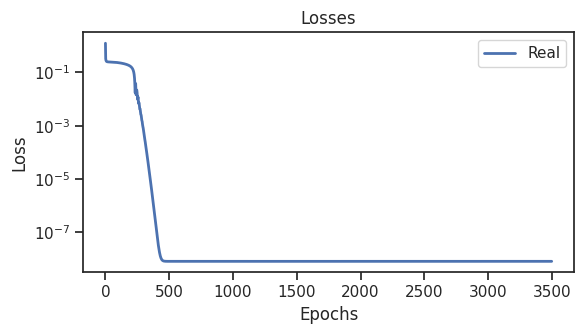

In [ ]:
# %%

## Save results: T, traj_length, losses, thetas, wall_time into a .npz file
np.savez(savepath, time_horizon_init=T, time_horizon_list=T_hrz_list, traj_length=traj_length, losses=losses, thetas=thetas, wall_time=wall_time, grad_norms=grad_norms)

sbplot(losses, "-", label="Real", y_scale="log", title="Losses", x_label="Epochs", y_label="Loss");

In [ ]:
# %%

# ## Test 3: Plot to training predictions
# X_full, t_full = batch
# t_eval_small = np.linspace(0, T_hrz.T, traj_length)

# X, _ = model_real(X_full, t_full, T_hrz.T)
# X_hat, _ = model(X_full[...,0,:], T_hrz.T)

# ax = sbplot(t_eval_small, X_hat[0, :, 0], "-", label="Predicted", title="Real vs Predicted", x_label="Time", y_label="Position")
# ax = sbplot(t_eval_small, X[0, :, 0], "x", label="Real", ax=ax)

In [ ]:
import jax
import jax.numpy as jnp
import numpy as np
from scipy.integrate import solve_ivp
import equinox as eqx
import diffrax
import optax
import time
import argparse

from neuralhub import params_norm, params_norm_squared, sbplot, RK4

try:
    __IPYTHON__
    _in_ipython_session = True
except NameError:
    _in_ipython_session = False


#%%

if _in_ipython_session:
	args = argparse.Namespace(time_horizon='39.396473', savepath="results_sgd_9/99999.npz", verbose=1)
	# args = argparse.Namespace(time_horizon='15.0', savepath="results_sgd_9/99999.npz", verbose=1)
else:
	parser = argparse.ArgumentParser(description='Description of your program')
	parser.add_argument('--time_horizon', type=str, help='Time Horizon T', default='10.00', required=False)
	parser.add_argument('--savepath', type=str, help='Save the results to', default='results/99999.npz', required=False)
	parser.add_argument('--verbose',type=int, help='Whether to print details or not ?', default=1, required=False)
	args = parser.parse_args()

T = float(args.time_horizon)
savepath = args.savepath
verbose = args.verbose

if verbose:
    print("\n############# Lotka-Volterra with Neural ODE #############\n")
    print("  - Initial time Horizon T: ", T)
    print("  - Savepath: ", savepath)

## Training hps
print_every = 300
nb_epochs = 3500
init_lr_mod = 1e-1
init_lr_T = 1e-1

traj_length = 25
skip_steps = 1

T_full = 100        ### All trajectories are this long, just in case !


############# Lotka-Volterra with Neural ODE #############

  - Initial time Horizon T:  39.396473
  - Savepath:  results_sgd_9/99999.npz


In [ ]:
#%%

def mass_spring_damper(t, state, k, mu, m):
    E = np.array([[0, 1], [-k/m, -mu/m]])
    return E @ state

p = {"k": 1, "mu": 0.25, "m": 1}
t_eval_full = np.linspace(0, T_full, (traj_length-1)*100+1)[::skip_steps]  ## Biggest t we can find !
initial_state = [1.0, 1.0]

solution = solve_ivp(mass_spring_damper, (0,T_full), initial_state, args=p.values(), t_eval=t_eval_full)
data = solution.y.T[None, None, ::, :]

# ## Test 0: Plot the data
# sbplot(t_eval_full, data[0, 0, :, 0], title="Mass-Spring-Damper: Position", x_label="Time", y_label="Position");

# ## Test 1: Plot the interpolation as well
# t_eval_small = np.linspace(0, T, traj_length)
# sol_int = np.interp(t_eval_small, t_eval_full, data[0, 0, :, 0])
# ax = sbplot(t_eval_small, sol_int, "-", title="Interpolation vs Renormalisation", x_label="Time", y_label="Position", label="Interpolated");

# ## Test 2: Integrate a renomalized vector field
# def mass_spring_damper_renormed(t, state, k, mu, m):
#     E = np.array([[0, 1], [-k/m, -mu/m]])
#     return T * (E @ state)
# t_renormed = np.linspace(0, 1, traj_length)
# sol_renormed = solve_ivp(mass_spring_damper_renormed, (0,1), initial_state, args=p.values(), t_eval=t_renormed)
# ax = sbplot(t_eval_small, sol_renormed.y[0], "x", label="Renormalized", y_label="Position", ax=ax);

In [ ]:
# %%

class Processor(eqx.Module):
    matrix: jnp.ndarray

    def __init__(self, in_size, out_size, key=None):
        self.matrix = jnp.array([[0., 0.], [0., 0.]])

    def __call__(self, t, x, args):
        T = args[0]
        return T * (self.matrix @ x)


class NeuralODE(eqx.Module):
    data_size: int
    vector_field: eqx.Module

    def __init__(self, data_size, key=None):
        self.data_size = data_size
        self.vector_field = Processor(data_size, data_size, key=key)

    def __call__(self, x0s, T):
        t_eval = jnp.linspace(0,1,traj_length)

        def integrate(y0):
            # sol = diffrax.diffeqsolve(
            #         diffrax.ODETerm(self.vector_field),
            #         diffrax.Tsit5(),
            #         t0=t_eval[0],
            #         t1=t_eval[-1],
            #         args=(T,),
            #         dt0=1e-3,
            #         y0=y0,
            #         stepsize_controller=diffrax.PIDController(rtol=1e-3, atol=1e-6),
            #         saveat=diffrax.SaveAt(ts=t_eval),
            #         # adjoint=diffrax.BacksolveAdjoint(),
            #         adjoint=diffrax.RecursiveCheckpointAdjoint(),
            #         max_steps=4096
            #     )
            # return sol.ys, sol.stats["num_steps"]

            sol = RK4(fun=self.vector_field, 
                      t_span=(t_eval[0], t_eval[-1]), 
                      y0=y0,
                      args=(T,T, T),
                      t_eval=t_eval, 
                      subdivisions=5)
            return sol, t_eval.shape[0]*5

        trajs, nb_fes = eqx.filter_vmap(integrate)(x0s)
        return trajs, jnp.sum(nb_fes)


def model_real(X_full, t_full, T):
    t_eval = jnp.linspace(0, T, traj_length)

    ## Interpolate X_full to t_eval
    X1 = jnp.interp(t_eval, t_full, X_full[0, ...,0])
    X2 = jnp.interp(t_eval, t_full, X_full[0, ...,1])

    return jnp.concatenate([X1, X2], axis=-1)[None,...], t_eval







class THorizon(eqx.Module):
    T: jnp.ndarray

    def __init__(self, init_T, key=None):
        self.T = jnp.array([init_T])

    def __call__(self):
        return self.T


model = NeuralODE(data_size=2)
T_hrz = THorizon(T)
mega_model = (model, T_hrz)

# model_real(jnp.array([1., 1.])[None, ...], T)
# print(data[0, :, 0].shape)
# model_real(data[:, :, 0], T)

In [ ]:
# %%

def loss_fn(mega_model, batch):
    model, T_hrz = mega_model
    X_full, t_full = batch
    X, _ = model_real(X_full, t_full, T_hrz.T)
    X_hat, _ = model(X_full[...,0,:], T_hrz.T)
    return jnp.mean((X - X_hat)**2)


@eqx.filter_jit
def mega_train_step(mega_model, batch, mega_opt_state):
    loss, mega_grads = eqx.filter_value_and_grad(loss_fn)(mega_model, batch)

    model, T_hrz = mega_model
    grads_mod, grads_T = mega_grads
    opt_state_mod, opt_state_T = mega_opt_state

    updates, opt_state_mod = opt_mod.update(grads_mod, opt_state_mod)
    model = eqx.apply_updates(model, updates)

    grad_norm = params_norm(grads_mod)
    # grad_norm = params_norm_squared(grads_mod)

    ## Only update T if the gradient norm if we are at bad saddle point (hessian has small eigenvalues) ##
    hessians = eqx.filter_hessian(loss_fn)(mega_model, batch)
    # jax.debug.print("hessians {}", hessians)
    hess_theta = hessians[0].vector_field.matrix[0].vector_field.matrix.reshape((4,4))
    eigvals = jnp.linalg.eigh(hess_theta)[0]
    # jax.debug.print("Eigenvalues: {}", eigvals)

    grads_T = jax.lax.cond(jnp.any(jnp.abs(eigvals)<1e-1), 
                            lambda y: jax.tree.map(lambda x: -x, y), 
                            lambda y: jax.tree.map(lambda x: jnp.zeros_like(x), y),
                            grads_T)
    updates, opt_state_T = opt_T.update(grads_T, opt_state_T)
    T_hrz = eqx.apply_updates(T_hrz, updates)

    return (model, T_hrz), (opt_state_mod, opt_state_T), loss, grad_norm



# @eqx.filter_jit
# def mega_train_step_fine(mega_model, batch, mega_opt_state):
#     loss, mega_grads = eqx.filter_value_and_grad(loss_fn)(mega_model, batch)

#     model, T_hrz = mega_model
#     grads_mod, grads_T = mega_grads
#     opt_state_mod, opt_state_T = mega_opt_state

#     updates, opt_state_mod = opt_mod.update(grads_mod, opt_state_mod)
#     model = eqx.apply_updates(model, updates)

#     grad_norm = params_norm(grads_mod)
#     # grad_norm = params_norm_squared(grads_mod)

#     ## Only update T if the gradient norm if we are at bad saddle point (hessian has small eigenvalues) ##
#     hessians = eqx.filter_hessian(loss_fn)(mega_model, batch)
#     # jax.debug.print("hessians {}", hessians)
#     hess_theta = hessians[0].vector_field.matrix[0].vector_field.matrix.reshape((4,4))
#     eigvals = jnp.linalg.eigh(hess_theta)[0]
#     # jax.debug.print("Eigenvalues: {}", eigvals)

#     grads_T = jax.lax.cond(jnp.any(jnp.abs(eigvals)<1e-1), 
#                             lambda y: jax.tree.map(lambda x: x, y), 
#                             lambda y: jax.tree.map(lambda x: jnp.zeros_like(x), y),
#                             grads_T)
#     updates, opt_state_T = opt_T.update(grads_T, opt_state_T)
#     T_hrz = eqx.apply_updates(T_hrz, updates)

#     return (model, T_hrz), (opt_state_mod, opt_state_T), loss, grad_norm



opt_mod = optax.adam(init_lr_mod)
opt_state_mod = opt_mod.init(eqx.filter(model, eqx.is_array))

opt_T = optax.adam(init_lr_T)
opt_state_T = opt_T.init(T_hrz)


if verbose:
    print("\n\n=== Beginning Training ... ===")

start_time = time.time()


losses = []
grad_norms = []
theta_list = [model.vector_field.matrix]
T_hrz_list = [T_hrz.T]

batch = data[0, :, :, :], t_eval_full

for epoch in range(nb_epochs):

    mega_model, opt_states, loss, grad_norm = mega_train_step((model, T_hrz), batch, (opt_state_mod, opt_state_T))

    model, T_hrz = mega_model
    opt_state_mod, opt_state_T = opt_states

    losses.append(loss)
    theta_list.append(model.vector_field.matrix)
    grad_norms.append(grad_norm)
    T_hrz_list.append(T_hrz.T)

    if verbose and (epoch%print_every==0 or epoch==nb_epochs-1):
        print(f"    Epoch: {epoch:-5d}      Loss: {loss:.12f}", flush=True)


# for epoch_fine in range(nb_epochs):

#     mega_model, opt_states, loss, grad_norm = mega_train_step_fine((model, T_hrz), batch, (opt_state_mod, opt_state_T))

#     model, T_hrz = mega_model
#     opt_state_mod, opt_state_T = opt_states

#     if verbose and (epoch_fine%print_every==0 or epoch_fine==nb_epochs-1):
#         print(f"    EpochFine: {epoch_fine:-5d}      Loss: {loss:.12f}", flush=True)



losses = jnp.stack(losses)
thetas = jnp.stack(theta_list)
grad_norms = jnp.stack(grad_norms)
T_hrz_list = jnp.stack(T_hrz_list)

wall_time = time.time() - start_time

if verbose:
    print("\nTotal GD training time: %d secs\n" %wall_time, flush=True)
    print("Final model matrix: \n", model.vector_field.matrix)
    print("Final T: ", T_hrz.T)



=== Beginning Training ... ===
    Epoch:     0      Loss: 1.084236025810
    Epoch:   300      Loss: 0.134874969721
    Epoch:   600      Loss: 0.000000015175
    Epoch:   900      Loss: 0.000000011673
    Epoch:  1200      Loss: 0.000000011673
    Epoch:  1500      Loss: 0.000000011673
    Epoch:  1800      Loss: 0.000000011672
    Epoch:  2100      Loss: 0.000000011672
    Epoch:  2400      Loss: 0.000000011672
    Epoch:  2700      Loss: 0.000000011671
    Epoch:  3000      Loss: 0.000000011670
    Epoch:  3300      Loss: 0.000000011670
    Epoch:  3499      Loss: 0.000000011671

Total GD training time: 26 secs

Final model matrix: 
 [[-1.5235666e-04  1.0001538e+00]
 [-1.0001571e+00 -2.5022849e-01]]
Final T:  [5.626336]


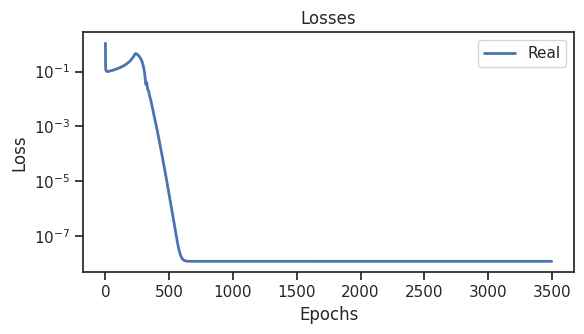

In [ ]:
# %%

## Save results: T, traj_length, losses, thetas, wall_time into a .npz file
np.savez(savepath, time_horizon_init=T, time_horizon_list=T_hrz_list, traj_length=traj_length, losses=losses, thetas=thetas, wall_time=wall_time, grad_norms=grad_norms)

sbplot(losses, "-", label="Real", y_scale="log", title="Losses", x_label="Epochs", y_label="Loss");

In [ ]:
# %%

# ## Test 3: Plot to training predictions
# X_full, t_full = batch
# t_eval_small = np.linspace(0, T_hrz.T, traj_length)

# X, _ = model_real(X_full, t_full, T_hrz.T)
# X_hat, _ = model(X_full[...,0,:], T_hrz.T)

# ax = sbplot(t_eval_small, X_hat[0, :, 0], "-", label="Predicted", title="Real vs Predicted", x_label="Time", y_label="Position")
# ax = sbplot(t_eval_small, X[0, :, 0], "x", label="Real", ax=ax)

In [ ]:
import jax
import jax.numpy as jnp
import numpy as np
from scipy.integrate import solve_ivp
import equinox as eqx
import diffrax
import optax
import time
import argparse

from neuralhub import params_norm, params_norm_squared, sbplot, RK4

try:
    __IPYTHON__
    _in_ipython_session = True
except NameError:
    _in_ipython_session = False


#%%

if _in_ipython_session:
	args = argparse.Namespace(time_horizon='39.396473', savepath="results_sgd_9/99999.npz", verbose=1)
	# args = argparse.Namespace(time_horizon='15.0', savepath="results_sgd_9/99999.npz", verbose=1)
else:
	parser = argparse.ArgumentParser(description='Description of your program')
	parser.add_argument('--time_horizon', type=str, help='Time Horizon T', default='10.00', required=False)
	parser.add_argument('--savepath', type=str, help='Save the results to', default='results/99999.npz', required=False)
	parser.add_argument('--verbose',type=int, help='Whether to print details or not ?', default=1, required=False)
	args = parser.parse_args()

T = float(args.time_horizon)
savepath = args.savepath
verbose = args.verbose

if verbose:
    print("\n############# Lotka-Volterra with Neural ODE #############\n")
    print("  - Initial time Horizon T: ", T)
    print("  - Savepath: ", savepath)

## Training hps
print_every = 300
nb_epochs = 3500
init_lr_mod = 1e-1
init_lr_T = 1e-1

traj_length = 25
skip_steps = 1

T_full = 100        ### All trajectories are this long, just in case !


############# Lotka-Volterra with Neural ODE #############

  - Initial time Horizon T:  39.396473
  - Savepath:  results_sgd_9/99999.npz


In [ ]:
#%%

def mass_spring_damper(t, state, k, mu, m):
    E = np.array([[0, 1], [-k/m, -mu/m]])
    return E @ state

p = {"k": 1, "mu": 0.25, "m": 1}
t_eval_full = np.linspace(0, T_full, (traj_length-1)*100+1)[::skip_steps]  ## Biggest t we can find !
initial_state = [1.0, 1.0]

solution = solve_ivp(mass_spring_damper, (0,T_full), initial_state, args=p.values(), t_eval=t_eval_full)
data = solution.y.T[None, None, ::, :]

# ## Test 0: Plot the data
# sbplot(t_eval_full, data[0, 0, :, 0], title="Mass-Spring-Damper: Position", x_label="Time", y_label="Position");

# ## Test 1: Plot the interpolation as well
# t_eval_small = np.linspace(0, T, traj_length)
# sol_int = np.interp(t_eval_small, t_eval_full, data[0, 0, :, 0])
# ax = sbplot(t_eval_small, sol_int, "-", title="Interpolation vs Renormalisation", x_label="Time", y_label="Position", label="Interpolated");

# ## Test 2: Integrate a renomalized vector field
# def mass_spring_damper_renormed(t, state, k, mu, m):
#     E = np.array([[0, 1], [-k/m, -mu/m]])
#     return T * (E @ state)
# t_renormed = np.linspace(0, 1, traj_length)
# sol_renormed = solve_ivp(mass_spring_damper_renormed, (0,1), initial_state, args=p.values(), t_eval=t_renormed)
# ax = sbplot(t_eval_small, sol_renormed.y[0], "x", label="Renormalized", y_label="Position", ax=ax);

In [ ]:
# %%

class Processor(eqx.Module):
    matrix: jnp.ndarray

    def __init__(self, in_size, out_size, key=None):
        self.matrix = jnp.array([[0., 0.], [0., 0.]])

    def __call__(self, t, x, args):
        T = args[0]
        return T * (self.matrix @ x)


class NeuralODE(eqx.Module):
    data_size: int
    vector_field: eqx.Module

    def __init__(self, data_size, key=None):
        self.data_size = data_size
        self.vector_field = Processor(data_size, data_size, key=key)

    def __call__(self, x0s, T):
        t_eval = jnp.linspace(0,1,traj_length)

        def integrate(y0):
            # sol = diffrax.diffeqsolve(
            #         diffrax.ODETerm(self.vector_field),
            #         diffrax.Tsit5(),
            #         t0=t_eval[0],
            #         t1=t_eval[-1],
            #         args=(T,),
            #         dt0=1e-3,
            #         y0=y0,
            #         stepsize_controller=diffrax.PIDController(rtol=1e-3, atol=1e-6),
            #         saveat=diffrax.SaveAt(ts=t_eval),
            #         # adjoint=diffrax.BacksolveAdjoint(),
            #         adjoint=diffrax.RecursiveCheckpointAdjoint(),
            #         max_steps=4096
            #     )
            # return sol.ys, sol.stats["num_steps"]

            sol = RK4(fun=self.vector_field, 
                      t_span=(t_eval[0], t_eval[-1]), 
                      y0=y0,
                      args=(T,T, T),
                      t_eval=t_eval, 
                      subdivisions=5)
            return sol, t_eval.shape[0]*5

        trajs, nb_fes = eqx.filter_vmap(integrate)(x0s)
        return trajs, jnp.sum(nb_fes)


def model_real(X_full, t_full, T):
    t_eval = jnp.linspace(0, T, traj_length)

    ## Interpolate X_full to t_eval
    X1 = jnp.interp(t_eval, t_full, X_full[0, ...,0])
    X2 = jnp.interp(t_eval, t_full, X_full[0, ...,1])

    return jnp.concatenate([X1, X2], axis=-1)[None,...], t_eval







class THorizon(eqx.Module):
    T: jnp.ndarray

    def __init__(self, init_T, key=None):
        self.T = jnp.array([init_T])

    def __call__(self):
        return self.T


model = NeuralODE(data_size=2)
T_hrz = THorizon(T)
mega_model = (model, T_hrz)

# model_real(jnp.array([1., 1.])[None, ...], T)
# print(data[0, :, 0].shape)
# model_real(data[:, :, 0], T)

In [ ]:
# %%

def loss_fn(mega_model, batch):
    model, T_hrz = mega_model
    X_full, t_full = batch
    X, _ = model_real(X_full, t_full, T_hrz.T)
    X_hat, _ = model(X_full[...,0,:], T_hrz.T)
    return jnp.mean((X - X_hat)**2)


@eqx.filter_jit
def mega_train_step(mega_model, batch, mega_opt_state):
    loss, mega_grads = eqx.filter_value_and_grad(loss_fn)(mega_model, batch)

    model, T_hrz = mega_model
    grads_mod, grads_T = mega_grads
    opt_state_mod, opt_state_T = mega_opt_state

    updates, opt_state_mod = opt_mod.update(grads_mod, opt_state_mod)
    model = eqx.apply_updates(model, updates)

    grad_norm = params_norm(grads_mod)
    # grad_norm = params_norm_squared(grads_mod)

    # ## Only update T if the gradient norm if we are at bad saddle point (hessian has small eigenvalues) ##
    # hessians = eqx.filter_hessian(loss_fn)(mega_model, batch)
    # # jax.debug.print("hessians {}", hessians)
    # hess_theta = hessians[0].vector_field.matrix[0].vector_field.matrix.reshape((4,4))
    # eigvals = jnp.linalg.eigh(hess_theta)[0]
    # # jax.debug.print("Eigenvalues: {}", eigvals)

    # grads_T = jax.lax.cond(jnp.any(jnp.abs(eigvals)<1e-1), 
    #                         lambda y: jax.tree.map(lambda x: -x, y), 
    #                         lambda y: jax.tree.map(lambda x: jnp.zeros_like(x), y),
    #                         grads_T)
    # updates, opt_state_T = opt_T.update(grads_T, opt_state_T)
    # T_hrz = eqx.apply_updates(T_hrz, updates)

    return (model, T_hrz), (opt_state_mod, opt_state_T), loss, grad_norm



# @eqx.filter_jit
# def mega_train_step_fine(mega_model, batch, mega_opt_state):
#     loss, mega_grads = eqx.filter_value_and_grad(loss_fn)(mega_model, batch)

#     model, T_hrz = mega_model
#     grads_mod, grads_T = mega_grads
#     opt_state_mod, opt_state_T = mega_opt_state

#     updates, opt_state_mod = opt_mod.update(grads_mod, opt_state_mod)
#     model = eqx.apply_updates(model, updates)

#     grad_norm = params_norm(grads_mod)
#     # grad_norm = params_norm_squared(grads_mod)

#     ## Only update T if the gradient norm if we are at bad saddle point (hessian has small eigenvalues) ##
#     hessians = eqx.filter_hessian(loss_fn)(mega_model, batch)
#     # jax.debug.print("hessians {}", hessians)
#     hess_theta = hessians[0].vector_field.matrix[0].vector_field.matrix.reshape((4,4))
#     eigvals = jnp.linalg.eigh(hess_theta)[0]
#     # jax.debug.print("Eigenvalues: {}", eigvals)

#     grads_T = jax.lax.cond(jnp.any(jnp.abs(eigvals)<1e-1), 
#                             lambda y: jax.tree.map(lambda x: x, y), 
#                             lambda y: jax.tree.map(lambda x: jnp.zeros_like(x), y),
#                             grads_T)
#     updates, opt_state_T = opt_T.update(grads_T, opt_state_T)
#     T_hrz = eqx.apply_updates(T_hrz, updates)

#     return (model, T_hrz), (opt_state_mod, opt_state_T), loss, grad_norm



opt_mod = optax.adam(init_lr_mod)
opt_state_mod = opt_mod.init(eqx.filter(model, eqx.is_array))

opt_T = optax.adam(init_lr_T)
opt_state_T = opt_T.init(T_hrz)


if verbose:
    print("\n\n=== Beginning Training ... ===")

start_time = time.time()


losses = []
grad_norms = []
theta_list = [model.vector_field.matrix]
T_hrz_list = [T_hrz.T]

batch = data[0, :, :, :], t_eval_full

for epoch in range(nb_epochs):

    mega_model, opt_states, loss, grad_norm = mega_train_step((model, T_hrz), batch, (opt_state_mod, opt_state_T))

    model, T_hrz = mega_model
    opt_state_mod, opt_state_T = opt_states

    losses.append(loss)
    theta_list.append(model.vector_field.matrix)
    grad_norms.append(grad_norm)
    T_hrz_list.append(T_hrz.T)

    if verbose and (epoch%print_every==0 or epoch==nb_epochs-1):
        print(f"    Epoch: {epoch:-5d}      Loss: {loss:.12f}", flush=True)


# for epoch_fine in range(nb_epochs):

#     mega_model, opt_states, loss, grad_norm = mega_train_step_fine((model, T_hrz), batch, (opt_state_mod, opt_state_T))

#     model, T_hrz = mega_model
#     opt_state_mod, opt_state_T = opt_states

#     if verbose and (epoch_fine%print_every==0 or epoch_fine==nb_epochs-1):
#         print(f"    EpochFine: {epoch_fine:-5d}      Loss: {loss:.12f}", flush=True)



losses = jnp.stack(losses)
thetas = jnp.stack(theta_list)
grad_norms = jnp.stack(grad_norms)
T_hrz_list = jnp.stack(T_hrz_list)

wall_time = time.time() - start_time

if verbose:
    print("\nTotal GD training time: %d secs\n" %wall_time, flush=True)
    print("Final model matrix: \n", model.vector_field.matrix)
    print("Final T: ", T_hrz.T)



=== Beginning Training ... ===
    Epoch:     0      Loss: 1.084236025810
    Epoch:   300      Loss: 0.089829079807
    Epoch:   600      Loss: 0.075248271227
    Epoch:   900      Loss: 0.001761545311
    Epoch:  1200      Loss: 0.000007062471
    Epoch:  1500      Loss: 0.000000009477
    Epoch:  1800      Loss: 0.000000001139
    Epoch:  2100      Loss: 0.000000001137
    Epoch:  2400      Loss: 0.000000001136
    Epoch:  2700      Loss: 0.000000001136
    Epoch:  3000      Loss: 0.000000001136
    Epoch:  3300      Loss: 0.000000001137
    Epoch:  3499      Loss: 0.000000001136

Total GD training time: 7 secs

Final model matrix: 
 [[-1.6515017e-04  1.0002383e+00]
 [-1.0002731e+00 -2.5030711e-01]]
Final T:  [39.396473]


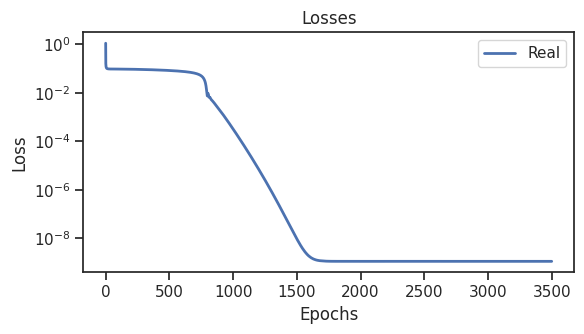

In [ ]:
# %%

## Save results: T, traj_length, losses, thetas, wall_time into a .npz file
np.savez(savepath, time_horizon_init=T, time_horizon_list=T_hrz_list, traj_length=traj_length, losses=losses, thetas=thetas, wall_time=wall_time, grad_norms=grad_norms)

sbplot(losses, "-", label="Real", y_scale="log", title="Losses", x_label="Epochs", y_label="Loss");

In [ ]:
# %%

# ## Test 3: Plot to training predictions
# X_full, t_full = batch
# t_eval_small = np.linspace(0, T_hrz.T, traj_length)

# X, _ = model_real(X_full, t_full, T_hrz.T)
# X_hat, _ = model(X_full[...,0,:], T_hrz.T)

# ax = sbplot(t_eval_small, X_hat[0, :, 0], "-", label="Predicted", title="Real vs Predicted", x_label="Time", y_label="Position")
# ax = sbplot(t_eval_small, X[0, :, 0], "x", label="Real", ax=ax)

In [ ]:
import jax
import jax.numpy as jnp
import numpy as np
from scipy.integrate import solve_ivp
import equinox as eqx
import diffrax
import optax
import time
import argparse

from neuralhub import params_norm, params_norm_squared, sbplot, RK4

try:
    __IPYTHON__
    _in_ipython_session = True
except NameError:
    _in_ipython_session = False


#%%

if _in_ipython_session:
	args = argparse.Namespace(time_horizon='39.396473', savepath="results_sgd_9/99999.npz", verbose=1)
	# args = argparse.Namespace(time_horizon='15.0', savepath="results_sgd_9/99999.npz", verbose=1)
else:
	parser = argparse.ArgumentParser(description='Description of your program')
	parser.add_argument('--time_horizon', type=str, help='Time Horizon T', default='10.00', required=False)
	parser.add_argument('--savepath', type=str, help='Save the results to', default='results/99999.npz', required=False)
	parser.add_argument('--verbose',type=int, help='Whether to print details or not ?', default=1, required=False)
	args = parser.parse_args()

T = float(args.time_horizon)
savepath = args.savepath
verbose = args.verbose

if verbose:
    print("\n############# Lotka-Volterra with Neural ODE #############\n")
    print("  - Initial time Horizon T: ", T)
    print("  - Savepath: ", savepath)

## Training hps
print_every = 300
nb_epochs = 3500
init_lr_mod = 1e-1
init_lr_T = 1e-1

traj_length = 25
skip_steps = 1

T_full = 100        ### All trajectories are this long, just in case !


############# Lotka-Volterra with Neural ODE #############

  - Initial time Horizon T:  39.396473
  - Savepath:  results_sgd_9/99999.npz


In [ ]:
#%%

def mass_spring_damper(t, state, k, mu, m):
    E = np.array([[0, 1], [-k/m, -mu/m]])
    return E @ state

p = {"k": 1, "mu": 0.25, "m": 1}
t_eval_full = np.linspace(0, T_full, (traj_length-1)*100+1)[::skip_steps]  ## Biggest t we can find !
initial_state = [1.0, 1.0]

solution = solve_ivp(mass_spring_damper, (0,T_full), initial_state, args=p.values(), t_eval=t_eval_full)
data = solution.y.T[None, None, ::, :]

# ## Test 0: Plot the data
# sbplot(t_eval_full, data[0, 0, :, 0], title="Mass-Spring-Damper: Position", x_label="Time", y_label="Position");

# ## Test 1: Plot the interpolation as well
# t_eval_small = np.linspace(0, T, traj_length)
# sol_int = np.interp(t_eval_small, t_eval_full, data[0, 0, :, 0])
# ax = sbplot(t_eval_small, sol_int, "-", title="Interpolation vs Renormalisation", x_label="Time", y_label="Position", label="Interpolated");

# ## Test 2: Integrate a renomalized vector field
# def mass_spring_damper_renormed(t, state, k, mu, m):
#     E = np.array([[0, 1], [-k/m, -mu/m]])
#     return T * (E @ state)
# t_renormed = np.linspace(0, 1, traj_length)
# sol_renormed = solve_ivp(mass_spring_damper_renormed, (0,1), initial_state, args=p.values(), t_eval=t_renormed)
# ax = sbplot(t_eval_small, sol_renormed.y[0], "x", label="Renormalized", y_label="Position", ax=ax);

In [ ]:
# %%

class Processor(eqx.Module):
    matrix: jnp.ndarray

    def __init__(self, in_size, out_size, key=None):
        self.matrix = jnp.array([[0., 0.], [0., 0.]])

    def __call__(self, t, x, args):
        T = args[0]
        return T * (self.matrix @ x)


class NeuralODE(eqx.Module):
    data_size: int
    vector_field: eqx.Module

    def __init__(self, data_size, key=None):
        self.data_size = data_size
        self.vector_field = Processor(data_size, data_size, key=key)

    def __call__(self, x0s, T):
        t_eval = jnp.linspace(0,1,traj_length)

        def integrate(y0):
            # sol = diffrax.diffeqsolve(
            #         diffrax.ODETerm(self.vector_field),
            #         diffrax.Tsit5(),
            #         t0=t_eval[0],
            #         t1=t_eval[-1],
            #         args=(T,),
            #         dt0=1e-3,
            #         y0=y0,
            #         stepsize_controller=diffrax.PIDController(rtol=1e-3, atol=1e-6),
            #         saveat=diffrax.SaveAt(ts=t_eval),
            #         # adjoint=diffrax.BacksolveAdjoint(),
            #         adjoint=diffrax.RecursiveCheckpointAdjoint(),
            #         max_steps=4096
            #     )
            # return sol.ys, sol.stats["num_steps"]

            sol = RK4(fun=self.vector_field, 
                      t_span=(t_eval[0], t_eval[-1]), 
                      y0=y0,
                      args=(T,T, T),
                      t_eval=t_eval, 
                      subdivisions=5)
            return sol, t_eval.shape[0]*5

        trajs, nb_fes = eqx.filter_vmap(integrate)(x0s)
        return trajs, jnp.sum(nb_fes)


def model_real(X_full, t_full, T):
    t_eval = jnp.linspace(0, T, traj_length)

    ## Interpolate X_full to t_eval
    X1 = jnp.interp(t_eval, t_full, X_full[0, ...,0])
    X2 = jnp.interp(t_eval, t_full, X_full[0, ...,1])

    return jnp.concatenate([X1, X2], axis=-1)[None,...], t_eval







class THorizon(eqx.Module):
    T: jnp.ndarray

    def __init__(self, init_T, key=None):
        self.T = jnp.array([init_T])

    def __call__(self):
        return self.T


model = NeuralODE(data_size=2)
T_hrz = THorizon(T)
mega_model = (model, T_hrz)

# model_real(jnp.array([1., 1.])[None, ...], T)
# print(data[0, :, 0].shape)
# model_real(data[:, :, 0], T)

In [ ]:
# %%

def loss_fn(mega_model, batch):
    model, T_hrz = mega_model
    X_full, t_full = batch
    X, _ = model_real(X_full, t_full, T_hrz.T)
    X_hat, _ = model(X_full[...,0,:], T_hrz.T)
    return jnp.mean((X - X_hat)**2)


@eqx.filter_jit
def mega_train_step(mega_model, batch, mega_opt_state):
    loss, mega_grads = eqx.filter_value_and_grad(loss_fn)(mega_model, batch)

    model, T_hrz = mega_model
    grads_mod, grads_T = mega_grads
    opt_state_mod, opt_state_T = mega_opt_state

    updates, opt_state_mod = opt_mod.update(grads_mod, opt_state_mod)
    model = eqx.apply_updates(model, updates)

    grad_norm = params_norm(grads_mod)
    # grad_norm = params_norm_squared(grads_mod)

    ## Only update T if the gradient norm if we are at bad saddle point (hessian has small eigenvalues) ##
    hessians = eqx.filter_hessian(loss_fn)(mega_model, batch)
    # jax.debug.print("hessians {}", hessians)
    hess_theta = hessians[0].vector_field.matrix[0].vector_field.matrix.reshape((4,4))
    eigvals = jnp.linalg.eigh(hess_theta)[0]
    # jax.debug.print("Eigenvalues: {}", eigvals)

    grads_T = jax.lax.cond(jnp.any(jnp.abs(eigvals)<1e-1), 
                            lambda y: jax.tree.map(lambda x: -x, y), 
                            lambda y: jax.tree.map(lambda x: jnp.zeros_like(x), y),
                            grads_T)
    updates, opt_state_T = opt_T.update(grads_T, opt_state_T)
    T_hrz = eqx.apply_updates(T_hrz, updates)

    return (model, T_hrz), (opt_state_mod, opt_state_T), loss, grad_norm



# @eqx.filter_jit
# def mega_train_step_fine(mega_model, batch, mega_opt_state):
#     loss, mega_grads = eqx.filter_value_and_grad(loss_fn)(mega_model, batch)

#     model, T_hrz = mega_model
#     grads_mod, grads_T = mega_grads
#     opt_state_mod, opt_state_T = mega_opt_state

#     updates, opt_state_mod = opt_mod.update(grads_mod, opt_state_mod)
#     model = eqx.apply_updates(model, updates)

#     grad_norm = params_norm(grads_mod)
#     # grad_norm = params_norm_squared(grads_mod)

#     ## Only update T if the gradient norm if we are at bad saddle point (hessian has small eigenvalues) ##
#     hessians = eqx.filter_hessian(loss_fn)(mega_model, batch)
#     # jax.debug.print("hessians {}", hessians)
#     hess_theta = hessians[0].vector_field.matrix[0].vector_field.matrix.reshape((4,4))
#     eigvals = jnp.linalg.eigh(hess_theta)[0]
#     # jax.debug.print("Eigenvalues: {}", eigvals)

#     grads_T = jax.lax.cond(jnp.any(jnp.abs(eigvals)<1e-1), 
#                             lambda y: jax.tree.map(lambda x: x, y), 
#                             lambda y: jax.tree.map(lambda x: jnp.zeros_like(x), y),
#                             grads_T)
#     updates, opt_state_T = opt_T.update(grads_T, opt_state_T)
#     T_hrz = eqx.apply_updates(T_hrz, updates)

#     return (model, T_hrz), (opt_state_mod, opt_state_T), loss, grad_norm



opt_mod = optax.adam(init_lr_mod)
opt_state_mod = opt_mod.init(eqx.filter(model, eqx.is_array))

opt_T = optax.adam(init_lr_T)
opt_state_T = opt_T.init(T_hrz)


if verbose:
    print("\n\n=== Beginning Training ... ===")

start_time = time.time()


losses = []
grad_norms = []
theta_list = [model.vector_field.matrix]
T_hrz_list = [T_hrz.T]

batch = data[0, :, :, :], t_eval_full

for epoch in range(nb_epochs):

    mega_model, opt_states, loss, grad_norm = mega_train_step((model, T_hrz), batch, (opt_state_mod, opt_state_T))

    model, T_hrz = mega_model
    opt_state_mod, opt_state_T = opt_states

    losses.append(loss)
    theta_list.append(model.vector_field.matrix)
    grad_norms.append(grad_norm)
    T_hrz_list.append(T_hrz.T)

    if verbose and (epoch%print_every==0 or epoch==nb_epochs-1):
        print(f"    Epoch: {epoch:-5d}      Loss: {loss:.12f}", flush=True)


# for epoch_fine in range(nb_epochs):

#     mega_model, opt_states, loss, grad_norm = mega_train_step_fine((model, T_hrz), batch, (opt_state_mod, opt_state_T))

#     model, T_hrz = mega_model
#     opt_state_mod, opt_state_T = opt_states

#     if verbose and (epoch_fine%print_every==0 or epoch_fine==nb_epochs-1):
#         print(f"    EpochFine: {epoch_fine:-5d}      Loss: {loss:.12f}", flush=True)



losses = jnp.stack(losses)
thetas = jnp.stack(theta_list)
grad_norms = jnp.stack(grad_norms)
T_hrz_list = jnp.stack(T_hrz_list)

wall_time = time.time() - start_time

if verbose:
    print("\nTotal GD training time: %d secs\n" %wall_time, flush=True)
    print("Final model matrix: \n", model.vector_field.matrix)
    print("Final T: ", T_hrz.T)



=== Beginning Training ... ===
    Epoch:     0      Loss: 1.084236025810
    Epoch:   300      Loss: 0.134874969721
    Epoch:   600      Loss: 0.000000015175
    Epoch:   900      Loss: 0.000000011673
    Epoch:  1200      Loss: 0.000000011673
    Epoch:  1500      Loss: 0.000000011673
    Epoch:  1800      Loss: 0.000000011672
    Epoch:  2100      Loss: 0.000000011672
    Epoch:  2400      Loss: 0.000000011672
    Epoch:  2700      Loss: 0.000000011671
    Epoch:  3000      Loss: 0.000000011670
    Epoch:  3300      Loss: 0.000000011670
    Epoch:  3499      Loss: 0.000000011671

Total GD training time: 26 secs

Final model matrix: 
 [[-1.5235666e-04  1.0001538e+00]
 [-1.0001571e+00 -2.5022849e-01]]
Final T:  [5.626336]


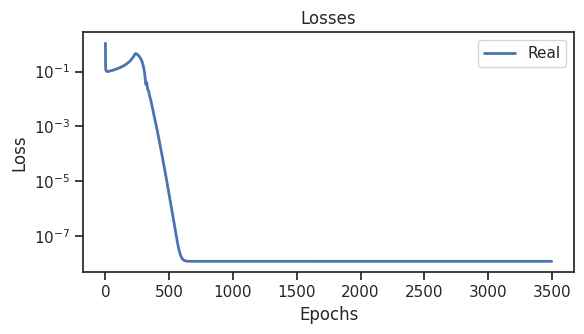

In [ ]:
# %%

## Save results: T, traj_length, losses, thetas, wall_time into a .npz file
np.savez(savepath, time_horizon_init=T, time_horizon_list=T_hrz_list, traj_length=traj_length, losses=losses, thetas=thetas, wall_time=wall_time, grad_norms=grad_norms)

sbplot(losses, "-", label="Real", y_scale="log", title="Losses", x_label="Epochs", y_label="Loss");

In [ ]:
# %%

# ## Test 3: Plot to training predictions
# X_full, t_full = batch
# t_eval_small = np.linspace(0, T_hrz.T, traj_length)

# X, _ = model_real(X_full, t_full, T_hrz.T)
# X_hat, _ = model(X_full[...,0,:], T_hrz.T)

# ax = sbplot(t_eval_small, X_hat[0, :, 0], "-", label="Predicted", title="Real vs Predicted", x_label="Time", y_label="Position")
# ax = sbplot(t_eval_small, X[0, :, 0], "x", label="Real", ax=ax)